# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/177/EEGNet_lstm/1-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: ShallowConvNet with bidirectional ConvLSTM2D (TODO)
   - Results (TODO)
   - Longer window experiment (TODO)
- New subject: EEGNet bidirectional LSTM (TODO)
   - Results (TODO)
   - Longer window experiment (TODO)
- New subject: ShallowConvNet with bidirectional ConvLSTM2D (TODO)
   - Results (TODO)
   - Longer window experiment (TODO)

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [5]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 100, 8)        400       
                                                                 
 batch_normalization (BatchN  (None, 21, 100, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 100, 16)       336       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1, 100, 16)        0         
                                                        

In [6]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9045 @ epoch 858
Best training loss (min) 0.3362 @ epoch 997

Best validation accuracy (max) 0.8021 @ epoch 75
Best validation loss (min) 0.5685 @ epoch 170

#### results for highest accuracy model ####
Accuracy of: 0.7083


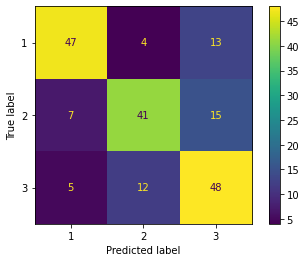


#### results for lowest loss model ####
Accuracy of: 0.7135


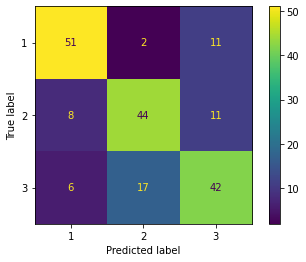


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9635 @ epoch 935
Best training loss (min) 0.1744 @ epoch 950

Best validation accuracy (max) 0.901 @ epoch 301
Best validation loss (min) 0.3569 @ epoch 376

#### results for highest accuracy model ####
Accuracy of: 0.9062


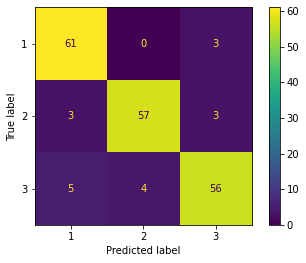


#### results for lowest loss model ####
Accuracy of: 0.8958


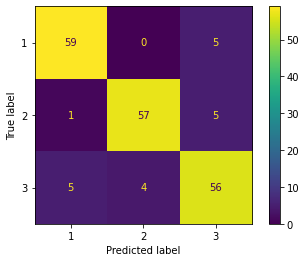


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9302 @ epoch 929
Best training loss (min) 0.2418 @ epoch 982

Best validation accuracy (max) 0.9058 @ epoch 478
Best validation loss (min) 0.3463 @ epoch 400

#### results for highest accuracy model ####
Accuracy of: 0.8272


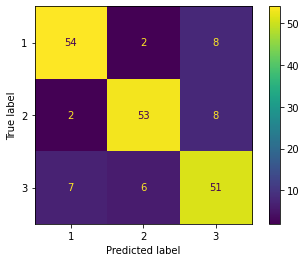


#### results for lowest loss model ####
Accuracy of: 0.8272


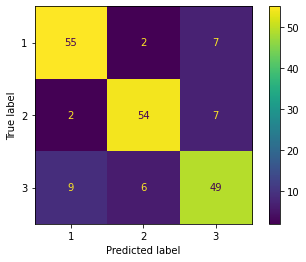

In [7]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [8]:
EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, ltsm_l2 = 0.0005
).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_6 (Batc  (None, 21, 100, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                             

In [9]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, ltsm_l2 = 0.0005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8177 @ epoch 448                             | 0.5194 @ epoch 345                         | 0.7083                                                     | 0.6927                                                      |
| C           | 0.8906 @ epoch 187                             | 0.3887 @ epoch 44                          | 0.8854                                                     | 0.8854                                                      |
| E           | 0.9215 @ epoch 339                             | 0.2673 @ epoch 443                         | 0.8429                                                     | 0.8639                                                      |


Again, for the most part results seems comparable although the result for subject B is considerably lower then EEGNet.
The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8299 @ epoch 350
Best training loss (min) 0.4749 @ epoch 464

Best validation accuracy (max) 0.8177 @ epoch 448
Best validation loss (min) 0.5194 @ epoch 345

#### results for highest accuracy model ####
Accuracy of: 0.7083


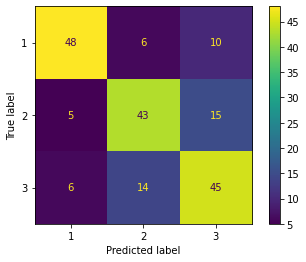


#### results for lowest loss model ####
Accuracy of: 0.6927


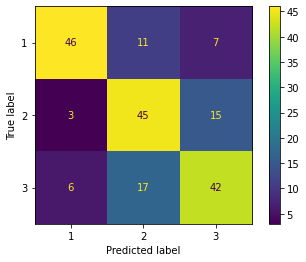


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9443 @ epoch 390
Best training loss (min) 0.2089 @ epoch 485

Best validation accuracy (max) 0.8906 @ epoch 187
Best validation loss (min) 0.3887 @ epoch 442

#### results for highest accuracy model ####
Accuracy of: 0.8854


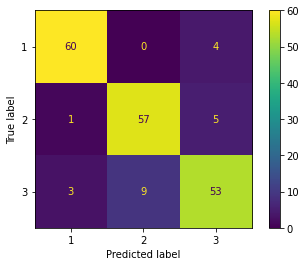


#### results for lowest loss model ####
Accuracy of: 0.8854


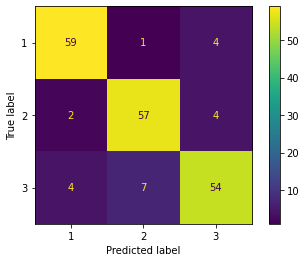


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.911 @ epoch 473
Best training loss (min) 0.275 @ epoch 473

Best validation accuracy (max) 0.9215 @ epoch 339
Best validation loss (min) 0.2673 @ epoch 443

#### results for highest accuracy model ####
Accuracy of: 0.8429


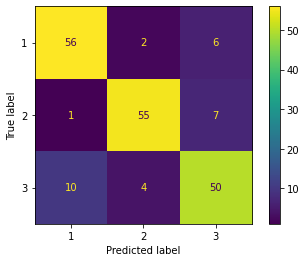


#### results for lowest loss model ####
Accuracy of: 0.8639


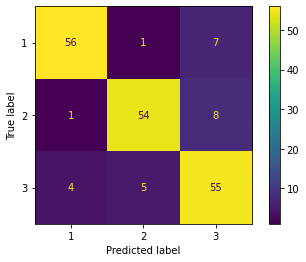

In [10]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs due to the increased amount of data, saving the best model based on best validation accuracy and validation loss (0.3 validation split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [16]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_25 (Bat  (None, 21, 100, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_9 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_26 (Bat  (None, 1, 100, 16)       64        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 1, 100, 16)        0         
                                                      

In [17]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (1918, 21, 100)
Epoch 1/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.4217 - accuracy: 0.3523
Epoch 1: val_loss improved from inf to 1.39771, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.32292, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 4s 110ms/step - loss: 1.4208 - accuracy: 0.3517 - val_loss: 1.3977 - val_accuracy: 0.3229
Epoch 2/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.3844 - accuracy: 0.3461
Epoch 2: val_loss improved from 1.39771 to 1.36191, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\t

Epoch 17/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0865 - accuracy: 0.4281
Epoch 17: val_loss improved from 1.09105 to 1.07021, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy did not improve from 0.48264
11/11 [==============================] - 0s 30ms/step - loss: 1.0854 - accuracy: 0.4300 - val_loss: 1.0702 - val_accuracy: 0.4688
Epoch 18/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0831 - accuracy: 0.4297
Epoch 18: val_loss did not improve from 1.07021

Epoch 18: val_accuracy did not improve from 0.48264
11/11 [==============================] - 0s 25ms/step - loss: 1.0794 - accuracy: 0.4404 - val_loss: 1.0716 - val_accuracy: 0.4705
Epoch 19/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0667 - accuracy: 0.4547
Epoch 19: val_loss improved from 1.07021 to 1.06759, saving model to saved_variables/7/EEGNet_lstm/samesubject_differents


Epoch 35: val_accuracy improved from 0.54340 to 0.56944, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 35ms/step - loss: 1.0181 - accuracy: 0.4963 - val_loss: 0.9762 - val_accuracy: 0.5694
Epoch 36/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0136 - accuracy: 0.5000
Epoch 36: val_loss did not improve from 0.97619

Epoch 36: val_accuracy did not improve from 0.56944
11/11 [==============================] - 0s 25ms/step - loss: 1.0145 - accuracy: 0.4993 - val_loss: 0.9785 - val_accuracy: 0.5538
Epoch 37/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0111 - accuracy: 0.5031
Epoch 37: val_loss improved from 0.97619 to 0.96548, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 37: val_accuracy improved from 0.56944 to 0.57292, saving model to saved_variables/7/

11/11 [==============================] - 0s 35ms/step - loss: 0.9611 - accuracy: 0.5492 - val_loss: 0.8942 - val_accuracy: 0.6215
Epoch 54/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9660 - accuracy: 0.5477
Epoch 54: val_loss improved from 0.89418 to 0.89251, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 54: val_accuracy did not improve from 0.62153
11/11 [==============================] - 0s 30ms/step - loss: 0.9607 - accuracy: 0.5551 - val_loss: 0.8925 - val_accuracy: 0.5885
Epoch 55/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9668 - accuracy: 0.5437
Epoch 55: val_loss did not improve from 0.89251

Epoch 55: val_accuracy did not improve from 0.62153
11/11 [==============================] - 0s 25ms/step - loss: 0.9652 - accuracy: 0.5469 - val_loss: 0.8975 - val_accuracy: 0.5920
Epoch 56/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9339 - accuracy

Epoch 77/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9153 - accuracy: 0.5813
Epoch 77: val_loss did not improve from 0.86624

Epoch 77: val_accuracy did not improve from 0.63368
11/11 [==============================] - 0s 25ms/step - loss: 0.9152 - accuracy: 0.5820 - val_loss: 0.8719 - val_accuracy: 0.6128
Epoch 78/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9360 - accuracy: 0.5641
Epoch 78: val_loss did not improve from 0.86624

Epoch 78: val_accuracy did not improve from 0.63368
11/11 [==============================] - 0s 25ms/step - loss: 0.9332 - accuracy: 0.5671 - val_loss: 0.8670 - val_accuracy: 0.6146
Epoch 79/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9375 - accuracy: 0.5742
Epoch 79: val_loss did not improve from 0.86624

Epoch 79: val_accuracy did not improve from 0.63368
11/11 [==============================] - 0s 24ms/step - loss: 0.9406 - accuracy: 0.5753 - val_loss: 0.8787 - val_accuracy: 0.6267
Epoch 80/1000
10

10/11 [==========================>...] - ETA: 0s - loss: 0.8892 - accuracy: 0.5914
Epoch 100: val_loss did not improve from 0.85454

Epoch 100: val_accuracy did not improve from 0.63368
11/11 [==============================] - 0s 25ms/step - loss: 0.8896 - accuracy: 0.5924 - val_loss: 0.8553 - val_accuracy: 0.6181
Epoch 101/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8874 - accuracy: 0.5977
Epoch 101: val_loss improved from 0.85454 to 0.85120, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 101: val_accuracy improved from 0.63368 to 0.63715, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 35ms/step - loss: 0.8917 - accuracy: 0.5931 - val_loss: 0.8512 - val_accuracy: 0.6372
Epoch 102/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8957 - accuracy: 0.6078
Epo

Epoch 123/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8892 - accuracy: 0.5898
Epoch 123: val_loss did not improve from 0.84028

Epoch 123: val_accuracy did not improve from 0.63715
11/11 [==============================] - 0s 25ms/step - loss: 0.8828 - accuracy: 0.5976 - val_loss: 0.8495 - val_accuracy: 0.6233
Epoch 124/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8925 - accuracy: 0.5797
Epoch 124: val_loss did not improve from 0.84028

Epoch 124: val_accuracy did not improve from 0.63715
11/11 [==============================] - 0s 25ms/step - loss: 0.8869 - accuracy: 0.5857 - val_loss: 0.8408 - val_accuracy: 0.6354
Epoch 125/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8726 - accuracy: 0.6187
Epoch 125: val_loss did not improve from 0.84028

Epoch 125: val_accuracy did not improve from 0.63715
11/11 [==============================] - 0s 25ms/step - loss: 0.8701 - accuracy: 0.6215 - val_loss: 0.8572 - val_accuracy: 0.6146
Epoch 1

Epoch 147/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8721 - accuracy: 0.6156
Epoch 147: val_loss improved from 0.83398 to 0.82969, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 147: val_accuracy did not improve from 0.64062
11/11 [==============================] - 0s 30ms/step - loss: 0.8697 - accuracy: 0.6133 - val_loss: 0.8297 - val_accuracy: 0.6337
Epoch 148/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8635 - accuracy: 0.6055
Epoch 148: val_loss did not improve from 0.82969

Epoch 148: val_accuracy did not improve from 0.64062
11/11 [==============================] - 0s 25ms/step - loss: 0.8641 - accuracy: 0.6058 - val_loss: 0.8458 - val_accuracy: 0.6302
Epoch 149/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8444 - accuracy: 0.6125
Epoch 149: val_loss did not improve from 0.82969

Epoch 149: val_accuracy did not improve from 0.64062
11/11 [====


Epoch 171: val_accuracy did not improve from 0.64062
11/11 [==============================] - 0s 25ms/step - loss: 0.8489 - accuracy: 0.6334 - val_loss: 0.8441 - val_accuracy: 0.6285
Epoch 172/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8512 - accuracy: 0.6289
Epoch 172: val_loss did not improve from 0.82969

Epoch 172: val_accuracy did not improve from 0.64062
11/11 [==============================] - 0s 25ms/step - loss: 0.8492 - accuracy: 0.6304 - val_loss: 0.8550 - val_accuracy: 0.6198
Epoch 173/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8378 - accuracy: 0.6336
Epoch 173: val_loss did not improve from 0.82969

Epoch 173: val_accuracy did not improve from 0.64062
11/11 [==============================] - 0s 25ms/step - loss: 0.8388 - accuracy: 0.6297 - val_loss: 0.8560 - val_accuracy: 0.6163
Epoch 174/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8407 - accuracy: 0.6195
Epoch 174: val_loss did not improve from 0.82969

Epoch 

Epoch 196/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8220 - accuracy: 0.6352
Epoch 196: val_loss did not improve from 0.82969

Epoch 196: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8231 - accuracy: 0.6326 - val_loss: 0.8668 - val_accuracy: 0.6076
Epoch 197/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8216 - accuracy: 0.6320
Epoch 197: val_loss did not improve from 0.82969

Epoch 197: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8162 - accuracy: 0.6356 - val_loss: 0.8489 - val_accuracy: 0.6233
Epoch 198/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8165 - accuracy: 0.6258
Epoch 198: val_loss did not improve from 0.82969

Epoch 198: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.8228 - accuracy: 0.6192 - val_loss: 0.8298 - val_accuracy: 0.6233
Epoch 1

Epoch 221/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8232 - accuracy: 0.6492
Epoch 221: val_loss did not improve from 0.82969

Epoch 221: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8243 - accuracy: 0.6505 - val_loss: 0.8476 - val_accuracy: 0.6233
Epoch 222/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8079 - accuracy: 0.6445
Epoch 222: val_loss did not improve from 0.82969

Epoch 222: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8059 - accuracy: 0.6438 - val_loss: 0.8615 - val_accuracy: 0.6181
Epoch 223/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8286 - accuracy: 0.6156
Epoch 223: val_loss did not improve from 0.82969

Epoch 223: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8309 - accuracy: 0.6155 - val_loss: 0.8500 - val_accuracy: 0.6146
Epoch 2

Epoch 246/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8080 - accuracy: 0.6477
Epoch 246: val_loss did not improve from 0.82969

Epoch 246: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8107 - accuracy: 0.6461 - val_loss: 0.8601 - val_accuracy: 0.6111
Epoch 247/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7959 - accuracy: 0.6562
Epoch 247: val_loss did not improve from 0.82969

Epoch 247: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7957 - accuracy: 0.6587 - val_loss: 0.8563 - val_accuracy: 0.6024
Epoch 248/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8036 - accuracy: 0.6477
Epoch 248: val_loss did not improve from 0.82969

Epoch 248: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.8054 - accuracy: 0.6498 - val_loss: 0.8554 - val_accuracy: 0.6146
Epoch 2

Epoch 271/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7956 - accuracy: 0.6570
Epoch 271: val_loss did not improve from 0.82969

Epoch 271: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7928 - accuracy: 0.6587 - val_loss: 0.8783 - val_accuracy: 0.6181
Epoch 272/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8076 - accuracy: 0.6406
Epoch 272: val_loss did not improve from 0.82969

Epoch 272: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8046 - accuracy: 0.6438 - val_loss: 0.8558 - val_accuracy: 0.6198
Epoch 273/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8160 - accuracy: 0.6281
Epoch 273: val_loss did not improve from 0.82969

Epoch 273: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.8171 - accuracy: 0.6244 - val_loss: 0.8613 - val_accuracy: 0.6267
Epoch 2

Epoch 296/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7876 - accuracy: 0.6539
Epoch 296: val_loss did not improve from 0.82969

Epoch 296: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7919 - accuracy: 0.6520 - val_loss: 0.8676 - val_accuracy: 0.6059
Epoch 297/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7823 - accuracy: 0.6609
Epoch 297: val_loss did not improve from 0.82969

Epoch 297: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7843 - accuracy: 0.6565 - val_loss: 0.8754 - val_accuracy: 0.6024
Epoch 298/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7761 - accuracy: 0.6641
Epoch 298: val_loss did not improve from 0.82969

Epoch 298: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7825 - accuracy: 0.6595 - val_loss: 0.8681 - val_accuracy: 0.6007
Epoch 2

Epoch 321/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7899 - accuracy: 0.6586
Epoch 321: val_loss did not improve from 0.82969

Epoch 321: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7864 - accuracy: 0.6610 - val_loss: 0.8699 - val_accuracy: 0.6198
Epoch 322/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7947 - accuracy: 0.6508
Epoch 322: val_loss did not improve from 0.82969

Epoch 322: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7953 - accuracy: 0.6490 - val_loss: 0.8734 - val_accuracy: 0.6059
Epoch 323/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7746 - accuracy: 0.6609
Epoch 323: val_loss did not improve from 0.82969

Epoch 323: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7800 - accuracy: 0.6602 - val_loss: 0.8774 - val_accuracy: 0.6094
Epoch 3

Epoch 346/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7626 - accuracy: 0.6703
Epoch 346: val_loss did not improve from 0.82969

Epoch 346: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7587 - accuracy: 0.6744 - val_loss: 0.8789 - val_accuracy: 0.6163
Epoch 347/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7614 - accuracy: 0.6766
Epoch 347: val_loss did not improve from 0.82969

Epoch 347: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7645 - accuracy: 0.6714 - val_loss: 0.8918 - val_accuracy: 0.6094
Epoch 348/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7565 - accuracy: 0.6797
Epoch 348: val_loss did not improve from 0.82969

Epoch 348: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7538 - accuracy: 0.6811 - val_loss: 0.8633 - val_accuracy: 0.6076
Epoch 3

Epoch 371/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7576 - accuracy: 0.6797
Epoch 371: val_loss did not improve from 0.82969

Epoch 371: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7520 - accuracy: 0.6803 - val_loss: 0.8818 - val_accuracy: 0.6076
Epoch 372/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7773 - accuracy: 0.6672
Epoch 372: val_loss did not improve from 0.82969

Epoch 372: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.7716 - accuracy: 0.6699 - val_loss: 0.8780 - val_accuracy: 0.6146
Epoch 373/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7410 - accuracy: 0.6992
Epoch 373: val_loss did not improve from 0.82969

Epoch 373: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.7405 - accuracy: 0.6990 - val_loss: 0.8822 - val_accuracy: 0.6094
Epoch 3

Epoch 396/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7438 - accuracy: 0.6891
Epoch 396: val_loss did not improve from 0.82969

Epoch 396: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7393 - accuracy: 0.6930 - val_loss: 0.8960 - val_accuracy: 0.6076
Epoch 397/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7358 - accuracy: 0.6836
Epoch 397: val_loss did not improve from 0.82969

Epoch 397: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7340 - accuracy: 0.6863 - val_loss: 0.8901 - val_accuracy: 0.6181
Epoch 398/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7586 - accuracy: 0.6695
Epoch 398: val_loss did not improve from 0.82969

Epoch 398: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7551 - accuracy: 0.6714 - val_loss: 0.8825 - val_accuracy: 0.6024
Epoch 3

Epoch 421/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7366 - accuracy: 0.6828
Epoch 421: val_loss did not improve from 0.82969

Epoch 421: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7429 - accuracy: 0.6826 - val_loss: 0.8969 - val_accuracy: 0.6024
Epoch 422/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7424 - accuracy: 0.6852
Epoch 422: val_loss did not improve from 0.82969

Epoch 422: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7417 - accuracy: 0.6870 - val_loss: 0.8894 - val_accuracy: 0.6076
Epoch 423/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7441 - accuracy: 0.6742
Epoch 423: val_loss did not improve from 0.82969

Epoch 423: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7451 - accuracy: 0.6766 - val_loss: 0.9018 - val_accuracy: 0.6111
Epoch 4

Epoch 446/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7425 - accuracy: 0.6812
Epoch 446: val_loss did not improve from 0.82969

Epoch 446: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.7489 - accuracy: 0.6788 - val_loss: 0.8980 - val_accuracy: 0.5990
Epoch 447/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7525 - accuracy: 0.6758
Epoch 447: val_loss did not improve from 0.82969

Epoch 447: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7511 - accuracy: 0.6796 - val_loss: 0.8970 - val_accuracy: 0.6111
Epoch 448/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7378 - accuracy: 0.6875
Epoch 448: val_loss did not improve from 0.82969

Epoch 448: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7383 - accuracy: 0.6893 - val_loss: 0.8929 - val_accuracy: 0.6094
Epoch 4

Epoch 471/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7200 - accuracy: 0.6969
Epoch 471: val_loss did not improve from 0.82969

Epoch 471: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 29ms/step - loss: 0.7210 - accuracy: 0.6945 - val_loss: 0.9253 - val_accuracy: 0.5938
Epoch 472/1000
11/11 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.7072
Epoch 472: val_loss did not improve from 0.82969

Epoch 472: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 32ms/step - loss: 0.7190 - accuracy: 0.7072 - val_loss: 0.9046 - val_accuracy: 0.5955
Epoch 473/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7290 - accuracy: 0.6984
Epoch 473: val_loss did not improve from 0.82969

Epoch 473: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.7289 - accuracy: 0.7012 - val_loss: 0.9001 - val_accuracy: 0.5972
Epoch 4

Epoch 496/1000
11/11 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.7057
Epoch 496: val_loss did not improve from 0.82969

Epoch 496: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 30ms/step - loss: 0.7293 - accuracy: 0.7057 - val_loss: 0.9153 - val_accuracy: 0.6042
Epoch 497/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7392 - accuracy: 0.6922
Epoch 497: val_loss did not improve from 0.82969

Epoch 497: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7322 - accuracy: 0.6960 - val_loss: 0.9163 - val_accuracy: 0.5938
Epoch 498/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7301 - accuracy: 0.6844
Epoch 498: val_loss did not improve from 0.82969

Epoch 498: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.7275 - accuracy: 0.6863 - val_loss: 0.9130 - val_accuracy: 0.5955
Epoch 4

Epoch 521/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7208 - accuracy: 0.6969
Epoch 521: val_loss did not improve from 0.82969

Epoch 521: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7230 - accuracy: 0.6990 - val_loss: 0.9077 - val_accuracy: 0.6094
Epoch 522/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6974 - accuracy: 0.7031
Epoch 522: val_loss did not improve from 0.82969

Epoch 522: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 27ms/step - loss: 0.6998 - accuracy: 0.7034 - val_loss: 0.9309 - val_accuracy: 0.5955
Epoch 523/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7261 - accuracy: 0.6969
Epoch 523: val_loss did not improve from 0.82969

Epoch 523: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 27ms/step - loss: 0.7274 - accuracy: 0.6945 - val_loss: 0.9289 - val_accuracy: 0.5938
Epoch 5

Epoch 546/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7298 - accuracy: 0.6945
Epoch 546: val_loss did not improve from 0.82969

Epoch 546: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 29ms/step - loss: 0.7289 - accuracy: 0.6923 - val_loss: 0.9002 - val_accuracy: 0.6007
Epoch 547/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6930 - accuracy: 0.7281
Epoch 547: val_loss did not improve from 0.82969

Epoch 547: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.6893 - accuracy: 0.7288 - val_loss: 0.9197 - val_accuracy: 0.5694
Epoch 548/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7070 - accuracy: 0.7203
Epoch 548: val_loss did not improve from 0.82969

Epoch 548: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.7049 - accuracy: 0.7221 - val_loss: 0.9256 - val_accuracy: 0.5833
Epoch 5

Epoch 571/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6999 - accuracy: 0.7273
Epoch 571: val_loss did not improve from 0.82969

Epoch 571: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6968 - accuracy: 0.7303 - val_loss: 0.9264 - val_accuracy: 0.5920
Epoch 572/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6889 - accuracy: 0.7180
Epoch 572: val_loss did not improve from 0.82969

Epoch 572: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 27ms/step - loss: 0.6978 - accuracy: 0.7109 - val_loss: 0.9373 - val_accuracy: 0.5920
Epoch 573/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6672 - accuracy: 0.7422
Epoch 573: val_loss did not improve from 0.82969

Epoch 573: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.6716 - accuracy: 0.7377 - val_loss: 0.9496 - val_accuracy: 0.5764
Epoch 5

Epoch 596/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6955 - accuracy: 0.7109
Epoch 596: val_loss did not improve from 0.82969

Epoch 596: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6945 - accuracy: 0.7131 - val_loss: 0.9312 - val_accuracy: 0.5920
Epoch 597/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6734 - accuracy: 0.7219
Epoch 597: val_loss did not improve from 0.82969

Epoch 597: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6729 - accuracy: 0.7243 - val_loss: 0.9448 - val_accuracy: 0.5903
Epoch 598/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6670 - accuracy: 0.7320
Epoch 598: val_loss did not improve from 0.82969

Epoch 598: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6652 - accuracy: 0.7317 - val_loss: 0.9336 - val_accuracy: 0.5938
Epoch 5

Epoch 621/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6967 - accuracy: 0.7203
Epoch 621: val_loss did not improve from 0.82969

Epoch 621: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 44ms/step - loss: 0.6930 - accuracy: 0.7243 - val_loss: 0.9337 - val_accuracy: 0.5816
Epoch 622/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6812 - accuracy: 0.7289
Epoch 622: val_loss did not improve from 0.82969

Epoch 622: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6823 - accuracy: 0.7280 - val_loss: 0.9444 - val_accuracy: 0.5747
Epoch 623/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6916 - accuracy: 0.7109
Epoch 623: val_loss did not improve from 0.82969

Epoch 623: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.6874 - accuracy: 0.7124 - val_loss: 0.9475 - val_accuracy: 0.5938
Epoch 6

Epoch 646/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6503 - accuracy: 0.7320
Epoch 646: val_loss did not improve from 0.82969

Epoch 646: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6538 - accuracy: 0.7325 - val_loss: 0.9312 - val_accuracy: 0.5781
Epoch 647/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6706 - accuracy: 0.7188
Epoch 647: val_loss did not improve from 0.82969

Epoch 647: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6661 - accuracy: 0.7221 - val_loss: 0.9504 - val_accuracy: 0.5642
Epoch 648/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6513 - accuracy: 0.7414
Epoch 648: val_loss did not improve from 0.82969

Epoch 648: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6510 - accuracy: 0.7422 - val_loss: 0.9479 - val_accuracy: 0.5608
Epoch 6

Epoch 671/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6476 - accuracy: 0.7492
Epoch 671: val_loss did not improve from 0.82969

Epoch 671: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6480 - accuracy: 0.7504 - val_loss: 0.9367 - val_accuracy: 0.5799
Epoch 672/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6813 - accuracy: 0.7164
Epoch 672: val_loss did not improve from 0.82969

Epoch 672: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.6766 - accuracy: 0.7228 - val_loss: 0.9530 - val_accuracy: 0.5712
Epoch 673/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6888 - accuracy: 0.7133
Epoch 673: val_loss did not improve from 0.82969

Epoch 673: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6829 - accuracy: 0.7168 - val_loss: 0.9673 - val_accuracy: 0.5833
Epoch 6

Epoch 696/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6578 - accuracy: 0.7336
Epoch 696: val_loss did not improve from 0.82969

Epoch 696: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.6504 - accuracy: 0.7407 - val_loss: 0.9481 - val_accuracy: 0.5955
Epoch 697/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6419 - accuracy: 0.7461
Epoch 697: val_loss did not improve from 0.82969

Epoch 697: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6443 - accuracy: 0.7459 - val_loss: 0.9511 - val_accuracy: 0.5955
Epoch 698/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6730 - accuracy: 0.7281
Epoch 698: val_loss did not improve from 0.82969

Epoch 698: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6690 - accuracy: 0.7295 - val_loss: 0.9408 - val_accuracy: 0.5955
Epoch 6

Epoch 721/1000
 9/11 [=======================>......] - ETA: 0s - loss: 0.6275 - accuracy: 0.7587
Epoch 721: val_loss did not improve from 0.82969

Epoch 721: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.6408 - accuracy: 0.7504 - val_loss: 0.9577 - val_accuracy: 0.5868
Epoch 722/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6252 - accuracy: 0.7570
Epoch 722: val_loss did not improve from 0.82969

Epoch 722: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6277 - accuracy: 0.7571 - val_loss: 0.9395 - val_accuracy: 0.5868
Epoch 723/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6579 - accuracy: 0.7359
Epoch 723: val_loss did not improve from 0.82969

Epoch 723: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6527 - accuracy: 0.7385 - val_loss: 0.9679 - val_accuracy: 0.5694
Epoch 7

Epoch 746/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6330 - accuracy: 0.7523
Epoch 746: val_loss did not improve from 0.82969

Epoch 746: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6307 - accuracy: 0.7526 - val_loss: 0.9458 - val_accuracy: 0.5920
Epoch 747/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6297 - accuracy: 0.7641
Epoch 747: val_loss did not improve from 0.82969

Epoch 747: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6278 - accuracy: 0.7653 - val_loss: 0.9727 - val_accuracy: 0.5885
Epoch 748/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6326 - accuracy: 0.7492
Epoch 748: val_loss did not improve from 0.82969

Epoch 748: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6321 - accuracy: 0.7466 - val_loss: 0.9585 - val_accuracy: 0.5851
Epoch 7

Epoch 771/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6070 - accuracy: 0.7664
Epoch 771: val_loss did not improve from 0.82969

Epoch 771: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6133 - accuracy: 0.7653 - val_loss: 0.9491 - val_accuracy: 0.5781
Epoch 772/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6480 - accuracy: 0.7414
Epoch 772: val_loss did not improve from 0.82969

Epoch 772: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6439 - accuracy: 0.7444 - val_loss: 0.9513 - val_accuracy: 0.5833
Epoch 773/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6270 - accuracy: 0.7555
Epoch 773: val_loss did not improve from 0.82969

Epoch 773: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6289 - accuracy: 0.7548 - val_loss: 0.9642 - val_accuracy: 0.5938
Epoch 7

Epoch 796/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6204 - accuracy: 0.7625
Epoch 796: val_loss did not improve from 0.82969

Epoch 796: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6256 - accuracy: 0.7586 - val_loss: 0.9723 - val_accuracy: 0.5816
Epoch 797/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6445 - accuracy: 0.7484
Epoch 797: val_loss did not improve from 0.82969

Epoch 797: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6424 - accuracy: 0.7481 - val_loss: 0.9825 - val_accuracy: 0.5816
Epoch 798/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6533 - accuracy: 0.7469
Epoch 798: val_loss did not improve from 0.82969

Epoch 798: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6488 - accuracy: 0.7496 - val_loss: 0.9920 - val_accuracy: 0.5625
Epoch 7

Epoch 821/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6076 - accuracy: 0.7711
Epoch 821: val_loss did not improve from 0.82969

Epoch 821: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6090 - accuracy: 0.7705 - val_loss: 0.9699 - val_accuracy: 0.5833
Epoch 822/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6159 - accuracy: 0.7555
Epoch 822: val_loss did not improve from 0.82969

Epoch 822: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6143 - accuracy: 0.7556 - val_loss: 0.9734 - val_accuracy: 0.5920
Epoch 823/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6223 - accuracy: 0.7555
Epoch 823: val_loss did not improve from 0.82969

Epoch 823: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6192 - accuracy: 0.7593 - val_loss: 0.9726 - val_accuracy: 0.5851
Epoch 8

Epoch 846/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6090 - accuracy: 0.7766
Epoch 846: val_loss did not improve from 0.82969

Epoch 846: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6134 - accuracy: 0.7727 - val_loss: 0.9851 - val_accuracy: 0.5747
Epoch 847/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6066 - accuracy: 0.7742
Epoch 847: val_loss did not improve from 0.82969

Epoch 847: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.6093 - accuracy: 0.7727 - val_loss: 0.9610 - val_accuracy: 0.5885
Epoch 848/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6134 - accuracy: 0.7633
Epoch 848: val_loss did not improve from 0.82969

Epoch 848: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.6176 - accuracy: 0.7601 - val_loss: 0.9776 - val_accuracy: 0.5816
Epoch 8

Epoch 871/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5951 - accuracy: 0.7734
Epoch 871: val_loss did not improve from 0.82969

Epoch 871: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5923 - accuracy: 0.7735 - val_loss: 0.9762 - val_accuracy: 0.5833
Epoch 872/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5893 - accuracy: 0.7875
Epoch 872: val_loss did not improve from 0.82969

Epoch 872: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5862 - accuracy: 0.7921 - val_loss: 0.9692 - val_accuracy: 0.6059
Epoch 873/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5962 - accuracy: 0.7719
Epoch 873: val_loss did not improve from 0.82969

Epoch 873: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5988 - accuracy: 0.7705 - val_loss: 0.9590 - val_accuracy: 0.6007
Epoch 8

Epoch 896/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6013 - accuracy: 0.7672
Epoch 896: val_loss did not improve from 0.82969

Epoch 896: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5993 - accuracy: 0.7683 - val_loss: 0.9972 - val_accuracy: 0.5764
Epoch 897/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6020 - accuracy: 0.7812
Epoch 897: val_loss did not improve from 0.82969

Epoch 897: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5963 - accuracy: 0.7846 - val_loss: 0.9972 - val_accuracy: 0.5677
Epoch 898/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5742 - accuracy: 0.7867
Epoch 898: val_loss did not improve from 0.82969

Epoch 898: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5763 - accuracy: 0.7861 - val_loss: 1.0007 - val_accuracy: 0.5677
Epoch 8

Epoch 921/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5640 - accuracy: 0.7953
Epoch 921: val_loss did not improve from 0.82969

Epoch 921: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 26ms/step - loss: 0.5599 - accuracy: 0.7988 - val_loss: 0.9944 - val_accuracy: 0.5677
Epoch 922/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5770 - accuracy: 0.7844
Epoch 922: val_loss did not improve from 0.82969

Epoch 922: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5766 - accuracy: 0.7839 - val_loss: 0.9923 - val_accuracy: 0.5712
Epoch 923/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5602 - accuracy: 0.7914
Epoch 923: val_loss did not improve from 0.82969

Epoch 923: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5609 - accuracy: 0.7906 - val_loss: 0.9815 - val_accuracy: 0.5885
Epoch 9

Epoch 946/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5574 - accuracy: 0.8008
Epoch 946: val_loss did not improve from 0.82969

Epoch 946: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5592 - accuracy: 0.7966 - val_loss: 1.0248 - val_accuracy: 0.5712
Epoch 947/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5911 - accuracy: 0.7695
Epoch 947: val_loss did not improve from 0.82969

Epoch 947: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5877 - accuracy: 0.7720 - val_loss: 1.0030 - val_accuracy: 0.5660
Epoch 948/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5518 - accuracy: 0.7953
Epoch 948: val_loss did not improve from 0.82969

Epoch 948: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5598 - accuracy: 0.7921 - val_loss: 1.0012 - val_accuracy: 0.5920
Epoch 9

Epoch 971/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5560 - accuracy: 0.8016
Epoch 971: val_loss did not improve from 0.82969

Epoch 971: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 24ms/step - loss: 0.5571 - accuracy: 0.8033 - val_loss: 1.0175 - val_accuracy: 0.5885
Epoch 972/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5796 - accuracy: 0.7883
Epoch 972: val_loss did not improve from 0.82969

Epoch 972: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5799 - accuracy: 0.7869 - val_loss: 0.9988 - val_accuracy: 0.5868
Epoch 973/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5526 - accuracy: 0.8047
Epoch 973: val_loss did not improve from 0.82969

Epoch 973: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5480 - accuracy: 0.8085 - val_loss: 0.9913 - val_accuracy: 0.5625
Epoch 9

Epoch 996/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5396 - accuracy: 0.8102
Epoch 996: val_loss did not improve from 0.82969

Epoch 996: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5439 - accuracy: 0.8085 - val_loss: 1.0015 - val_accuracy: 0.5868
Epoch 997/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5737 - accuracy: 0.7867
Epoch 997: val_loss did not improve from 0.82969

Epoch 997: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5705 - accuracy: 0.7891 - val_loss: 0.9953 - val_accuracy: 0.5833
Epoch 998/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5371 - accuracy: 0.8250
Epoch 998: val_loss did not improve from 0.82969

Epoch 998: val_accuracy did not improve from 0.64583
11/11 [==============================] - 0s 25ms/step - loss: 0.5353 - accuracy: 0.8256 - val_loss: 1.0065 - val_accuracy: 0.5885
Epoch 9


Epoch 12: val_accuracy improved from 0.74306 to 0.75000, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 36ms/step - loss: 0.7325 - accuracy: 0.7433 - val_loss: 0.7340 - val_accuracy: 0.7500
Epoch 13/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6961 - accuracy: 0.7453
Epoch 13: val_loss improved from 0.73402 to 0.68511, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 13: val_accuracy did not improve from 0.75000
11/11 [==============================] - 0s 30ms/step - loss: 0.6927 - accuracy: 0.7470 - val_loss: 0.6851 - val_accuracy: 0.7431
Epoch 14/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6978 - accuracy: 0.7484
Epoch 14: val_loss improved from 0.68511 to 0.65536, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\tra

Epoch 31/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5307 - accuracy: 0.8117
Epoch 31: val_loss did not improve from 0.54466

Epoch 31: val_accuracy did not improve from 0.80729
11/11 [==============================] - 0s 25ms/step - loss: 0.5359 - accuracy: 0.8073 - val_loss: 0.5619 - val_accuracy: 0.8056
Epoch 32/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5313 - accuracy: 0.8102
Epoch 32: val_loss did not improve from 0.54466

Epoch 32: val_accuracy did not improve from 0.80729
11/11 [==============================] - 0s 24ms/step - loss: 0.5329 - accuracy: 0.8110 - val_loss: 0.5542 - val_accuracy: 0.7986
Epoch 33/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5319 - accuracy: 0.8039
Epoch 33: val_loss did not improve from 0.54466

Epoch 33: val_accuracy did not improve from 0.80729
11/11 [==============================] - 0s 25ms/step - loss: 0.5294 - accuracy: 0.8058 - val_loss: 0.5485 - val_accuracy: 0.8056
Epoch 34/1000
10

10/11 [==========================>...] - ETA: 0s - loss: 0.4430 - accuracy: 0.8484
Epoch 54: val_loss improved from 0.53029 to 0.52881, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 54: val_accuracy did not improve from 0.81250
11/11 [==============================] - 0s 30ms/step - loss: 0.4450 - accuracy: 0.8460 - val_loss: 0.5288 - val_accuracy: 0.8056
Epoch 55/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4377 - accuracy: 0.8484
Epoch 55: val_loss did not improve from 0.52881

Epoch 55: val_accuracy did not improve from 0.81250
11/11 [==============================] - 0s 25ms/step - loss: 0.4417 - accuracy: 0.8467 - val_loss: 0.5307 - val_accuracy: 0.8021
Epoch 56/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4694 - accuracy: 0.8375
Epoch 56: val_loss did not improve from 0.52881

Epoch 56: val_accuracy did not improve from 0.81250
11/11 [===========================

11/11 [==============================] - 0s 25ms/step - loss: 0.4001 - accuracy: 0.8757 - val_loss: 0.5166 - val_accuracy: 0.8090
Epoch 78/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3759 - accuracy: 0.8781
Epoch 78: val_loss did not improve from 0.50825

Epoch 78: val_accuracy improved from 0.81944 to 0.82118, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.3784 - accuracy: 0.8757 - val_loss: 0.5201 - val_accuracy: 0.8212
Epoch 79/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4040 - accuracy: 0.8680
Epoch 79: val_loss did not improve from 0.50825

Epoch 79: val_accuracy did not improve from 0.82118
11/11 [==============================] - 0s 25ms/step - loss: 0.4010 - accuracy: 0.8690 - val_loss: 0.5396 - val_accuracy: 0.8177
Epoch 80/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4005 - accuracy

10/11 [==========================>...] - ETA: 0s - loss: 0.3595 - accuracy: 0.8820
Epoch 100: val_loss did not improve from 0.49201

Epoch 100: val_accuracy did not improve from 0.82292
11/11 [==============================] - 0s 25ms/step - loss: 0.3587 - accuracy: 0.8847 - val_loss: 0.5145 - val_accuracy: 0.8212
Epoch 101/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3559 - accuracy: 0.8828
Epoch 101: val_loss did not improve from 0.49201

Epoch 101: val_accuracy did not improve from 0.82292
11/11 [==============================] - 0s 25ms/step - loss: 0.3584 - accuracy: 0.8817 - val_loss: 0.5230 - val_accuracy: 0.8160
Epoch 102/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3729 - accuracy: 0.8750
Epoch 102: val_loss did not improve from 0.49201

Epoch 102: val_accuracy improved from 0.82292 to 0.82639, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [===================

Epoch 124/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3423 - accuracy: 0.8852
Epoch 124: val_loss did not improve from 0.49063

Epoch 124: val_accuracy did not improve from 0.83333
11/11 [==============================] - 0s 25ms/step - loss: 0.3379 - accuracy: 0.8869 - val_loss: 0.4951 - val_accuracy: 0.8281
Epoch 125/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3360 - accuracy: 0.8938
Epoch 125: val_loss did not improve from 0.49063

Epoch 125: val_accuracy did not improve from 0.83333
11/11 [==============================] - 0s 24ms/step - loss: 0.3365 - accuracy: 0.8921 - val_loss: 0.5070 - val_accuracy: 0.8229
Epoch 126/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3403 - accuracy: 0.8945
Epoch 126: val_loss did not improve from 0.49063

Epoch 126: val_accuracy did not improve from 0.83333
11/11 [==============================] - 0s 25ms/step - loss: 0.3387 - accuracy: 0.8951 - val_loss: 0.5162 - val_accuracy: 0.8108
Epoch 1

Epoch 148/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3118 - accuracy: 0.8984
Epoch 148: val_loss improved from 0.47483 to 0.47184, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 148: val_accuracy did not improve from 0.84201
11/11 [==============================] - 0s 30ms/step - loss: 0.3077 - accuracy: 0.8996 - val_loss: 0.4718 - val_accuracy: 0.8281
Epoch 149/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3092 - accuracy: 0.9023
Epoch 149: val_loss did not improve from 0.47184

Epoch 149: val_accuracy did not improve from 0.84201
11/11 [==============================] - 0s 25ms/step - loss: 0.3083 - accuracy: 0.9025 - val_loss: 0.5070 - val_accuracy: 0.8177
Epoch 150/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2959 - accuracy: 0.9039
Epoch 150: val_loss did not improve from 0.47184

Epoch 150: val_accuracy did not improve from 0.84201
11/11 [====

Epoch 172/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3054 - accuracy: 0.9055
Epoch 172: val_loss did not improve from 0.46858

Epoch 172: val_accuracy did not improve from 0.84201
11/11 [==============================] - 0s 25ms/step - loss: 0.3033 - accuracy: 0.9077 - val_loss: 0.5388 - val_accuracy: 0.8108
Epoch 173/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3054 - accuracy: 0.9078
Epoch 173: val_loss did not improve from 0.46858

Epoch 173: val_accuracy did not improve from 0.84201
11/11 [==============================] - 0s 24ms/step - loss: 0.3058 - accuracy: 0.9077 - val_loss: 0.5168 - val_accuracy: 0.8194
Epoch 174/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2971 - accuracy: 0.9070
Epoch 174: val_loss did not improve from 0.46858

Epoch 174: val_accuracy did not improve from 0.84201
11/11 [==============================] - 0s 24ms/step - loss: 0.2997 - accuracy: 0.9048 - val_loss: 0.5186 - val_accuracy: 0.8194
Epoch 1


Epoch 196: val_accuracy improved from 0.84201 to 0.84375, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.2931 - accuracy: 0.8973 - val_loss: 0.4780 - val_accuracy: 0.8438
Epoch 197/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2924 - accuracy: 0.9055
Epoch 197: val_loss did not improve from 0.46646

Epoch 197: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2898 - accuracy: 0.9070 - val_loss: 0.5048 - val_accuracy: 0.8351
Epoch 198/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2854 - accuracy: 0.9156
Epoch 198: val_loss did not improve from 0.46646

Epoch 198: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2869 - accuracy: 0.9144 - val_loss: 0.4919 - val_accuracy: 0.8194
Epoch 199/1000
10/11 [======

Epoch 221/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2764 - accuracy: 0.9164
Epoch 221: val_loss did not improve from 0.46646

Epoch 221: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2836 - accuracy: 0.9122 - val_loss: 0.4992 - val_accuracy: 0.8264
Epoch 222/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2746 - accuracy: 0.9187
Epoch 222: val_loss did not improve from 0.46646

Epoch 222: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2761 - accuracy: 0.9167 - val_loss: 0.4982 - val_accuracy: 0.8281
Epoch 223/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2916 - accuracy: 0.9055
Epoch 223: val_loss did not improve from 0.46646

Epoch 223: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 26ms/step - loss: 0.2961 - accuracy: 0.9033 - val_loss: 0.5071 - val_accuracy: 0.8247
Epoch 2

Epoch 246/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2620 - accuracy: 0.9250
Epoch 246: val_loss did not improve from 0.46646

Epoch 246: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2573 - accuracy: 0.9271 - val_loss: 0.5058 - val_accuracy: 0.8247
Epoch 247/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2667 - accuracy: 0.9180
Epoch 247: val_loss did not improve from 0.46646

Epoch 247: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2686 - accuracy: 0.9182 - val_loss: 0.5027 - val_accuracy: 0.8247
Epoch 248/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2796 - accuracy: 0.9039
Epoch 248: val_loss did not improve from 0.46646

Epoch 248: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2853 - accuracy: 0.9025 - val_loss: 0.4854 - val_accuracy: 0.8351
Epoch 2


Epoch 270: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2826 - accuracy: 0.9040 - val_loss: 0.4989 - val_accuracy: 0.8368
Epoch 271/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2494 - accuracy: 0.9242
Epoch 271: val_loss did not improve from 0.46432

Epoch 271: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2508 - accuracy: 0.9241 - val_loss: 0.5077 - val_accuracy: 0.8229
Epoch 272/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2772 - accuracy: 0.9094
Epoch 272: val_loss did not improve from 0.46432

Epoch 272: val_accuracy did not improve from 0.84375
11/11 [==============================] - 0s 25ms/step - loss: 0.2776 - accuracy: 0.9107 - val_loss: 0.5033 - val_accuracy: 0.8177
Epoch 273/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2655 - accuracy: 0.9148
Epoch 273: val_loss did not improve from 0.46432

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.2655 - accuracy: 0.9219
Epoch 294: val_loss did not improve from 0.44649

Epoch 294: val_accuracy did not improve from 0.85069
11/11 [==============================] - 0s 24ms/step - loss: 0.2645 - accuracy: 0.9219 - val_loss: 0.4644 - val_accuracy: 0.8438
Epoch 295/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2681 - accuracy: 0.9125
Epoch 295: val_loss did not improve from 0.44649

Epoch 295: val_accuracy did not improve from 0.85069
11/11 [==============================] - 0s 25ms/step - loss: 0.2701 - accuracy: 0.9137 - val_loss: 0.4686 - val_accuracy: 0.8438
Epoch 296/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2618 - accuracy: 0.9211
Epoch 296: val_loss did not improve from 0.44649

Epoch 296: val_accuracy did not improve from 0.85069
11/11 [==============================] - 0s 25ms/step - loss: 0.2614 - accuracy: 0.9219 - val_loss: 0.4657 - val_accuracy: 0.8368
Epoch 297/1000
10/11 [

Epoch 319/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2499 - accuracy: 0.9211
Epoch 319: val_loss did not improve from 0.44649

Epoch 319: val_accuracy did not improve from 0.85069
11/11 [==============================] - 0s 25ms/step - loss: 0.2529 - accuracy: 0.9211 - val_loss: 0.4780 - val_accuracy: 0.8299
Epoch 320/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2532 - accuracy: 0.9234
Epoch 320: val_loss did not improve from 0.44649

Epoch 320: val_accuracy did not improve from 0.85069
11/11 [==============================] - 0s 25ms/step - loss: 0.2597 - accuracy: 0.9219 - val_loss: 0.4739 - val_accuracy: 0.8333
Epoch 321/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2405 - accuracy: 0.9273
Epoch 321: val_loss did not improve from 0.44649

Epoch 321: val_accuracy did not improve from 0.85069
11/11 [==============================] - 0s 25ms/step - loss: 0.2410 - accuracy: 0.9278 - val_loss: 0.4937 - val_accuracy: 0.8264
Epoch 3

Epoch 343/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2471 - accuracy: 0.9203
Epoch 343: val_loss did not improve from 0.44484

Epoch 343: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2452 - accuracy: 0.9226 - val_loss: 0.5185 - val_accuracy: 0.8177
Epoch 344/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2628 - accuracy: 0.9133
Epoch 344: val_loss did not improve from 0.44484

Epoch 344: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2654 - accuracy: 0.9122 - val_loss: 0.5133 - val_accuracy: 0.8281
Epoch 345/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2648 - accuracy: 0.9148
Epoch 345: val_loss did not improve from 0.44484

Epoch 345: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2680 - accuracy: 0.9129 - val_loss: 0.5154 - val_accuracy: 0.8177
Epoch 3

Epoch 368/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2439 - accuracy: 0.9258
Epoch 368: val_loss did not improve from 0.44484

Epoch 368: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2494 - accuracy: 0.9249 - val_loss: 0.4715 - val_accuracy: 0.8420
Epoch 369/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2438 - accuracy: 0.9266
Epoch 369: val_loss did not improve from 0.44484

Epoch 369: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 24ms/step - loss: 0.2478 - accuracy: 0.9249 - val_loss: 0.4855 - val_accuracy: 0.8264
Epoch 370/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2640 - accuracy: 0.9117
Epoch 370: val_loss did not improve from 0.44484

Epoch 370: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2628 - accuracy: 0.9122 - val_loss: 0.4796 - val_accuracy: 0.8333
Epoch 3


Epoch 392: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2475 - accuracy: 0.9256 - val_loss: 0.4796 - val_accuracy: 0.8351
Epoch 393/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2407 - accuracy: 0.9227
Epoch 393: val_loss did not improve from 0.44110

Epoch 393: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2410 - accuracy: 0.9226 - val_loss: 0.4764 - val_accuracy: 0.8333
Epoch 394/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2437 - accuracy: 0.9195
Epoch 394: val_loss did not improve from 0.44110

Epoch 394: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2395 - accuracy: 0.9211 - val_loss: 0.4716 - val_accuracy: 0.8351
Epoch 395/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2358 - accuracy: 0.9266
Epoch 395: val_loss did not improve from 0.44110

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.2567 - accuracy: 0.9297
Epoch 417: val_loss did not improve from 0.44110

Epoch 417: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2503 - accuracy: 0.9330 - val_loss: 0.4548 - val_accuracy: 0.8368
Epoch 418/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2470 - accuracy: 0.9187
Epoch 418: val_loss did not improve from 0.44110

Epoch 418: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2477 - accuracy: 0.9182 - val_loss: 0.4772 - val_accuracy: 0.8368
Epoch 419/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2495 - accuracy: 0.9195
Epoch 419: val_loss did not improve from 0.44110

Epoch 419: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2473 - accuracy: 0.9219 - val_loss: 0.4838 - val_accuracy: 0.8299
Epoch 420/1000
10/11 [

Epoch 442/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2352 - accuracy: 0.9328
Epoch 442: val_loss did not improve from 0.44110

Epoch 442: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2356 - accuracy: 0.9338 - val_loss: 0.4713 - val_accuracy: 0.8264
Epoch 443/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2288 - accuracy: 0.9305
Epoch 443: val_loss did not improve from 0.44110

Epoch 443: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2253 - accuracy: 0.9323 - val_loss: 0.4953 - val_accuracy: 0.8229
Epoch 444/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2375 - accuracy: 0.9305
Epoch 444: val_loss did not improve from 0.44110

Epoch 444: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2369 - accuracy: 0.9308 - val_loss: 0.4909 - val_accuracy: 0.8333
Epoch 4

Epoch 467/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2324 - accuracy: 0.9258
Epoch 467: val_loss did not improve from 0.44110

Epoch 467: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2384 - accuracy: 0.9234 - val_loss: 0.4695 - val_accuracy: 0.8333
Epoch 468/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2537 - accuracy: 0.9234
Epoch 468: val_loss did not improve from 0.44110

Epoch 468: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2626 - accuracy: 0.9189 - val_loss: 0.4681 - val_accuracy: 0.8351
Epoch 469/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2693 - accuracy: 0.9117
Epoch 469: val_loss did not improve from 0.44110

Epoch 469: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2690 - accuracy: 0.9122 - val_loss: 0.4794 - val_accuracy: 0.8264
Epoch 4

Epoch 492/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2319 - accuracy: 0.9305
Epoch 492: val_loss did not improve from 0.44110

Epoch 492: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2330 - accuracy: 0.9293 - val_loss: 0.5169 - val_accuracy: 0.8212
Epoch 493/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2588 - accuracy: 0.9172
Epoch 493: val_loss did not improve from 0.44110

Epoch 493: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2592 - accuracy: 0.9167 - val_loss: 0.4822 - val_accuracy: 0.8281
Epoch 494/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2374 - accuracy: 0.9242
Epoch 494: val_loss did not improve from 0.44110

Epoch 494: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2358 - accuracy: 0.9241 - val_loss: 0.4749 - val_accuracy: 0.8333
Epoch 4

Epoch 517/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2327 - accuracy: 0.9258
Epoch 517: val_loss did not improve from 0.44110

Epoch 517: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2295 - accuracy: 0.9271 - val_loss: 0.4827 - val_accuracy: 0.8281
Epoch 518/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2267 - accuracy: 0.9258
Epoch 518: val_loss did not improve from 0.44110

Epoch 518: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 24ms/step - loss: 0.2238 - accuracy: 0.9263 - val_loss: 0.4916 - val_accuracy: 0.8281
Epoch 519/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2291 - accuracy: 0.9281
Epoch 519: val_loss did not improve from 0.44110

Epoch 519: val_accuracy did not improve from 0.85243
11/11 [==============================] - 0s 25ms/step - loss: 0.2294 - accuracy: 0.9278 - val_loss: 0.4679 - val_accuracy: 0.8333
Epoch 5


Epoch 541: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2386 - accuracy: 0.9286 - val_loss: 0.4829 - val_accuracy: 0.8351
Epoch 542/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2388 - accuracy: 0.9289
Epoch 542: val_loss did not improve from 0.44110

Epoch 542: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2379 - accuracy: 0.9286 - val_loss: 0.4825 - val_accuracy: 0.8403
Epoch 543/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2294 - accuracy: 0.9289
Epoch 543: val_loss did not improve from 0.44110

Epoch 543: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 26ms/step - loss: 0.2276 - accuracy: 0.9301 - val_loss: 0.4652 - val_accuracy: 0.8333
Epoch 544/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2368 - accuracy: 0.9305
Epoch 544: val_loss did not improve from 0.44110

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.2263 - accuracy: 0.9305
Epoch 566: val_loss did not improve from 0.44110

Epoch 566: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2258 - accuracy: 0.9301 - val_loss: 0.4565 - val_accuracy: 0.8368
Epoch 567/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2340 - accuracy: 0.9305
Epoch 567: val_loss did not improve from 0.44110

Epoch 567: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2319 - accuracy: 0.9308 - val_loss: 0.4772 - val_accuracy: 0.8472
Epoch 568/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2363 - accuracy: 0.9266
Epoch 568: val_loss did not improve from 0.44110

Epoch 568: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2352 - accuracy: 0.9271 - val_loss: 0.4883 - val_accuracy: 0.8299
Epoch 569/1000
10/11 [


Epoch 590: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2275 - accuracy: 0.9308 - val_loss: 0.4538 - val_accuracy: 0.8455
Epoch 591/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2273 - accuracy: 0.9305
Epoch 591: val_loss did not improve from 0.43484

Epoch 591: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2247 - accuracy: 0.9315 - val_loss: 0.4439 - val_accuracy: 0.8420
Epoch 592/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2101 - accuracy: 0.9406
Epoch 592: val_loss did not improve from 0.43484

Epoch 592: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2182 - accuracy: 0.9368 - val_loss: 0.4628 - val_accuracy: 0.8385
Epoch 593/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2289 - accuracy: 0.9289
Epoch 593: val_loss did not improve from 0.43484

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.2094 - accuracy: 0.9375
Epoch 615: val_loss did not improve from 0.43484

Epoch 615: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 24ms/step - loss: 0.2085 - accuracy: 0.9382 - val_loss: 0.4613 - val_accuracy: 0.8385
Epoch 616/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2148 - accuracy: 0.9297
Epoch 616: val_loss did not improve from 0.43484

Epoch 616: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2144 - accuracy: 0.9301 - val_loss: 0.4602 - val_accuracy: 0.8403
Epoch 617/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2107 - accuracy: 0.9406
Epoch 617: val_loss did not improve from 0.43484

Epoch 617: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2139 - accuracy: 0.9375 - val_loss: 0.4690 - val_accuracy: 0.8368
Epoch 618/1000
10/11 [

Epoch 640/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2235 - accuracy: 0.9359
Epoch 640: val_loss did not improve from 0.43484

Epoch 640: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2212 - accuracy: 0.9360 - val_loss: 0.4633 - val_accuracy: 0.8420
Epoch 641/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2105 - accuracy: 0.9383
Epoch 641: val_loss did not improve from 0.43484

Epoch 641: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2082 - accuracy: 0.9397 - val_loss: 0.4724 - val_accuracy: 0.8299
Epoch 642/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2039 - accuracy: 0.9438
Epoch 642: val_loss did not improve from 0.43484

Epoch 642: val_accuracy did not improve from 0.85417
11/11 [==============================] - 0s 25ms/step - loss: 0.2038 - accuracy: 0.9442 - val_loss: 0.5096 - val_accuracy: 0.8316
Epoch 6

Epoch 664/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2151 - accuracy: 0.9406
Epoch 664: val_loss did not improve from 0.42212

Epoch 664: val_accuracy did not improve from 0.85764
11/11 [==============================] - 0s 25ms/step - loss: 0.2164 - accuracy: 0.9405 - val_loss: 0.4322 - val_accuracy: 0.8472
Epoch 665/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2117 - accuracy: 0.9359
Epoch 665: val_loss did not improve from 0.42212

Epoch 665: val_accuracy did not improve from 0.85764
11/11 [==============================] - 0s 25ms/step - loss: 0.2170 - accuracy: 0.9330 - val_loss: 0.4451 - val_accuracy: 0.8403
Epoch 666/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2196 - accuracy: 0.9414
Epoch 666: val_loss did not improve from 0.42212

Epoch 666: val_accuracy did not improve from 0.85764
11/11 [==============================] - 0s 25ms/step - loss: 0.2195 - accuracy: 0.9412 - val_loss: 0.4526 - val_accuracy: 0.8472
Epoch 6

Epoch 689/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2217 - accuracy: 0.9367
Epoch 689: val_loss did not improve from 0.42212

Epoch 689: val_accuracy did not improve from 0.85764
11/11 [==============================] - 0s 25ms/step - loss: 0.2228 - accuracy: 0.9368 - val_loss: 0.4277 - val_accuracy: 0.8507
Epoch 690/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2157 - accuracy: 0.9461
Epoch 690: val_loss improved from 0.42212 to 0.42055, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 690: val_accuracy improved from 0.85764 to 0.86111, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 36ms/step - loss: 0.2150 - accuracy: 0.9457 - val_loss: 0.4205 - val_accuracy: 0.8611
Epoch 691/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2069 - accur

Epoch 713/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2140 - accuracy: 0.9375
Epoch 713: val_loss did not improve from 0.42055

Epoch 713: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2137 - accuracy: 0.9382 - val_loss: 0.4546 - val_accuracy: 0.8403
Epoch 714/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2405 - accuracy: 0.9281
Epoch 714: val_loss did not improve from 0.42055

Epoch 714: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2381 - accuracy: 0.9293 - val_loss: 0.4614 - val_accuracy: 0.8420
Epoch 715/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1953 - accuracy: 0.9430
Epoch 715: val_loss did not improve from 0.42055

Epoch 715: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.1931 - accuracy: 0.9435 - val_loss: 0.4684 - val_accuracy: 0.8420
Epoch 7

Epoch 738/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2177 - accuracy: 0.9297
Epoch 738: val_loss did not improve from 0.42055

Epoch 738: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2146 - accuracy: 0.9315 - val_loss: 0.4761 - val_accuracy: 0.8385
Epoch 739/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1996 - accuracy: 0.9391
Epoch 739: val_loss did not improve from 0.42055

Epoch 739: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.1974 - accuracy: 0.9397 - val_loss: 0.4940 - val_accuracy: 0.8194
Epoch 740/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2074 - accuracy: 0.9391
Epoch 740: val_loss did not improve from 0.42055

Epoch 740: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2078 - accuracy: 0.9375 - val_loss: 0.4643 - val_accuracy: 0.8351
Epoch 7

Epoch 763/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2078 - accuracy: 0.9328
Epoch 763: val_loss did not improve from 0.42055

Epoch 763: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2063 - accuracy: 0.9315 - val_loss: 0.4767 - val_accuracy: 0.8351
Epoch 764/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2148 - accuracy: 0.9305
Epoch 764: val_loss did not improve from 0.42055

Epoch 764: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2185 - accuracy: 0.9293 - val_loss: 0.4768 - val_accuracy: 0.8299
Epoch 765/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2203 - accuracy: 0.9383
Epoch 765: val_loss did not improve from 0.42055

Epoch 765: val_accuracy did not improve from 0.86111
11/11 [==============================] - 0s 25ms/step - loss: 0.2189 - accuracy: 0.9382 - val_loss: 0.4755 - val_accuracy: 0.8264
Epoch 7

Epoch 787/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2025 - accuracy: 0.9414
Epoch 787: val_loss did not improve from 0.41175

Epoch 787: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 24ms/step - loss: 0.2018 - accuracy: 0.9412 - val_loss: 0.4694 - val_accuracy: 0.8385
Epoch 788/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1983 - accuracy: 0.9453
Epoch 788: val_loss did not improve from 0.41175

Epoch 788: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2005 - accuracy: 0.9442 - val_loss: 0.4373 - val_accuracy: 0.8524
Epoch 789/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2143 - accuracy: 0.9312
Epoch 789: val_loss did not improve from 0.41175

Epoch 789: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2083 - accuracy: 0.9345 - val_loss: 0.4423 - val_accuracy: 0.8472
Epoch 7

Epoch 812/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2148 - accuracy: 0.9367
Epoch 812: val_loss did not improve from 0.41175

Epoch 812: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2163 - accuracy: 0.9360 - val_loss: 0.4319 - val_accuracy: 0.8524
Epoch 813/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2212 - accuracy: 0.9328
Epoch 813: val_loss did not improve from 0.41175

Epoch 813: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2248 - accuracy: 0.9308 - val_loss: 0.4210 - val_accuracy: 0.8542
Epoch 814/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2105 - accuracy: 0.9367
Epoch 814: val_loss did not improve from 0.41175

Epoch 814: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2071 - accuracy: 0.9390 - val_loss: 0.4461 - val_accuracy: 0.8438
Epoch 8

Epoch 837/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2121 - accuracy: 0.9328
Epoch 837: val_loss did not improve from 0.41175

Epoch 837: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2148 - accuracy: 0.9330 - val_loss: 0.4513 - val_accuracy: 0.8455
Epoch 838/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2069 - accuracy: 0.9414
Epoch 838: val_loss did not improve from 0.41175

Epoch 838: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2049 - accuracy: 0.9427 - val_loss: 0.4732 - val_accuracy: 0.8368
Epoch 839/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2168 - accuracy: 0.9352
Epoch 839: val_loss did not improve from 0.41175

Epoch 839: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2158 - accuracy: 0.9353 - val_loss: 0.4454 - val_accuracy: 0.8385
Epoch 8

Epoch 862/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2124 - accuracy: 0.9398
Epoch 862: val_loss did not improve from 0.41175

Epoch 862: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2094 - accuracy: 0.9420 - val_loss: 0.4742 - val_accuracy: 0.8316
Epoch 863/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2197 - accuracy: 0.9367
Epoch 863: val_loss did not improve from 0.41175

Epoch 863: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2230 - accuracy: 0.9353 - val_loss: 0.4560 - val_accuracy: 0.8472
Epoch 864/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1842 - accuracy: 0.9508
Epoch 864: val_loss did not improve from 0.41175

Epoch 864: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.1908 - accuracy: 0.9479 - val_loss: 0.4448 - val_accuracy: 0.8490
Epoch 8

Epoch 887/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2030 - accuracy: 0.9406
Epoch 887: val_loss did not improve from 0.41175

Epoch 887: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2011 - accuracy: 0.9420 - val_loss: 0.4750 - val_accuracy: 0.8368
Epoch 888/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2049 - accuracy: 0.9391
Epoch 888: val_loss did not improve from 0.41175

Epoch 888: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2118 - accuracy: 0.9353 - val_loss: 0.4787 - val_accuracy: 0.8368
Epoch 889/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2106 - accuracy: 0.9344
Epoch 889: val_loss did not improve from 0.41175

Epoch 889: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2117 - accuracy: 0.9338 - val_loss: 0.4647 - val_accuracy: 0.8316
Epoch 8

Epoch 912/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2001 - accuracy: 0.9414
Epoch 912: val_loss did not improve from 0.41175

Epoch 912: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.1971 - accuracy: 0.9427 - val_loss: 0.4472 - val_accuracy: 0.8490
Epoch 913/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2021 - accuracy: 0.9445
Epoch 913: val_loss did not improve from 0.41175

Epoch 913: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2005 - accuracy: 0.9442 - val_loss: 0.4523 - val_accuracy: 0.8455
Epoch 914/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2021 - accuracy: 0.9484
Epoch 914: val_loss did not improve from 0.41175

Epoch 914: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.1999 - accuracy: 0.9487 - val_loss: 0.4525 - val_accuracy: 0.8472
Epoch 9

Epoch 937/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1867 - accuracy: 0.9414
Epoch 937: val_loss did not improve from 0.41175

Epoch 937: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 24ms/step - loss: 0.1869 - accuracy: 0.9427 - val_loss: 0.4473 - val_accuracy: 0.8472
Epoch 938/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1960 - accuracy: 0.9414
Epoch 938: val_loss did not improve from 0.41175

Epoch 938: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.1935 - accuracy: 0.9427 - val_loss: 0.4377 - val_accuracy: 0.8490
Epoch 939/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2069 - accuracy: 0.9383
Epoch 939: val_loss did not improve from 0.41175

Epoch 939: val_accuracy did not improve from 0.86285
11/11 [==============================] - 0s 25ms/step - loss: 0.2106 - accuracy: 0.9360 - val_loss: 0.4422 - val_accuracy: 0.8420
Epoch 9


Epoch 961: val_accuracy did not improve from 0.86806
11/11 [==============================] - 0s 25ms/step - loss: 0.1978 - accuracy: 0.9442 - val_loss: 0.4662 - val_accuracy: 0.8455
Epoch 962/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2087 - accuracy: 0.9367
Epoch 962: val_loss did not improve from 0.41175

Epoch 962: val_accuracy did not improve from 0.86806
11/11 [==============================] - 0s 25ms/step - loss: 0.2100 - accuracy: 0.9345 - val_loss: 0.4774 - val_accuracy: 0.8490
Epoch 963/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2048 - accuracy: 0.9406
Epoch 963: val_loss did not improve from 0.41175

Epoch 963: val_accuracy did not improve from 0.86806
11/11 [==============================] - 0s 25ms/step - loss: 0.2057 - accuracy: 0.9382 - val_loss: 0.4484 - val_accuracy: 0.8368
Epoch 964/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2074 - accuracy: 0.9375
Epoch 964: val_loss did not improve from 0.41175

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.1847 - accuracy: 0.9461
Epoch 986: val_loss did not improve from 0.41175

Epoch 986: val_accuracy did not improve from 0.86806
11/11 [==============================] - 0s 25ms/step - loss: 0.1854 - accuracy: 0.9442 - val_loss: 0.4452 - val_accuracy: 0.8472
Epoch 987/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1868 - accuracy: 0.9477
Epoch 987: val_loss did not improve from 0.41175

Epoch 987: val_accuracy did not improve from 0.86806
11/11 [==============================] - 0s 25ms/step - loss: 0.1879 - accuracy: 0.9464 - val_loss: 0.4664 - val_accuracy: 0.8420
Epoch 988/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2132 - accuracy: 0.9281
Epoch 988: val_loss did not improve from 0.41175

Epoch 988: val_accuracy did not improve from 0.86806
11/11 [==============================] - 0s 25ms/step - loss: 0.2123 - accuracy: 0.9278 - val_loss: 0.4734 - val_accuracy: 0.8438
Epoch 989/1000
10/11 [

Epoch 7/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0280 - accuracy: 0.5898
Epoch 7: val_loss improved from 1.07200 to 1.04055, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 7: val_accuracy did not improve from 0.54688
11/11 [==============================] - 0s 31ms/step - loss: 1.0299 - accuracy: 0.5846 - val_loss: 1.0406 - val_accuracy: 0.5434
Epoch 8/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9921 - accuracy: 0.5867
Epoch 8: val_loss improved from 1.04055 to 1.03636, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 8: val_accuracy did not improve from 0.54688
11/11 [==============================] - 0s 30ms/step - loss: 0.9922 - accuracy: 0.5876 - val_loss: 1.0364 - val_accuracy: 0.5399
Epoch 9/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9689 - accuracy: 0.5969
Ep

Epoch 23/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7796 - accuracy: 0.6695
Epoch 23: val_loss did not improve from 0.78289

Epoch 23: val_accuracy did not improve from 0.69097
11/11 [==============================] - 0s 25ms/step - loss: 0.7766 - accuracy: 0.6711 - val_loss: 0.7884 - val_accuracy: 0.6788
Epoch 24/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7774 - accuracy: 0.6516
Epoch 24: val_loss did not improve from 0.78289

Epoch 24: val_accuracy did not improve from 0.69097
11/11 [==============================] - 0s 26ms/step - loss: 0.7808 - accuracy: 0.6510 - val_loss: 0.7838 - val_accuracy: 0.6823
Epoch 25/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7835 - accuracy: 0.6656
Epoch 25: val_loss did not improve from 0.78289

Epoch 25: val_accuracy did not improve from 0.69097
11/11 [==============================] - 0s 25ms/step - loss: 0.7861 - accuracy: 0.6629 - val_loss: 0.7901 - val_accuracy: 0.6736
Epoch 26/1000
10

Epoch 43/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6920 - accuracy: 0.7188
Epoch 43: val_loss did not improve from 0.70063

Epoch 43: val_accuracy did not improve from 0.72569
11/11 [==============================] - 0s 25ms/step - loss: 0.6994 - accuracy: 0.7159 - val_loss: 0.7194 - val_accuracy: 0.6892
Epoch 44/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7073 - accuracy: 0.7180
Epoch 44: val_loss did not improve from 0.70063

Epoch 44: val_accuracy did not improve from 0.72569
11/11 [==============================] - 0s 25ms/step - loss: 0.7066 - accuracy: 0.7181 - val_loss: 0.7205 - val_accuracy: 0.6944
Epoch 45/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6960 - accuracy: 0.7078
Epoch 45: val_loss did not improve from 0.70063

Epoch 45: val_accuracy did not improve from 0.72569
11/11 [==============================] - 0s 25ms/step - loss: 0.7005 - accuracy: 0.7077 - val_loss: 0.7160 - val_accuracy: 0.6962
Epoch 46/1000
10


Epoch 66: val_accuracy did not improve from 0.72569
11/11 [==============================] - 0s 25ms/step - loss: 0.6741 - accuracy: 0.7136 - val_loss: 0.7003 - val_accuracy: 0.6997
Epoch 67/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6589 - accuracy: 0.7437
Epoch 67: val_loss did not improve from 0.68218

Epoch 67: val_accuracy did not improve from 0.72569
11/11 [==============================] - 0s 24ms/step - loss: 0.6621 - accuracy: 0.7435 - val_loss: 0.6879 - val_accuracy: 0.7135
Epoch 68/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6532 - accuracy: 0.7320
Epoch 68: val_loss did not improve from 0.68218

Epoch 68: val_accuracy did not improve from 0.72569
11/11 [==============================] - 0s 25ms/step - loss: 0.6526 - accuracy: 0.7293 - val_loss: 0.6831 - val_accuracy: 0.7135
Epoch 69/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6479 - accuracy: 0.7375
Epoch 69: val_loss did not improve from 0.68218

Epoch 69: val_a

11/11 [==============================] - 0s 25ms/step - loss: 0.6416 - accuracy: 0.7472 - val_loss: 0.6855 - val_accuracy: 0.7049
Epoch 90/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6531 - accuracy: 0.7344
Epoch 90: val_loss did not improve from 0.66166

Epoch 90: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.6573 - accuracy: 0.7308 - val_loss: 0.6826 - val_accuracy: 0.7014
Epoch 91/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6292 - accuracy: 0.7563
Epoch 91: val_loss did not improve from 0.66166

Epoch 91: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.6273 - accuracy: 0.7584 - val_loss: 0.6687 - val_accuracy: 0.7188
Epoch 92/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6349 - accuracy: 0.7484
Epoch 92: val_loss did not improve from 0.66166

Epoch 92: val_accuracy did not improve from 0.73090
11/11 [=========

11/11 [==============================] - 0s 24ms/step - loss: 0.6249 - accuracy: 0.7539 - val_loss: 0.6868 - val_accuracy: 0.6962
Epoch 115/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6473 - accuracy: 0.7437
Epoch 115: val_loss did not improve from 0.66166

Epoch 115: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.6394 - accuracy: 0.7472 - val_loss: 0.6693 - val_accuracy: 0.7066
Epoch 116/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6183 - accuracy: 0.7516
Epoch 116: val_loss did not improve from 0.66166

Epoch 116: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.6239 - accuracy: 0.7494 - val_loss: 0.6770 - val_accuracy: 0.6979
Epoch 117/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5937 - accuracy: 0.7789
Epoch 117: val_loss did not improve from 0.66166

Epoch 117: val_accuracy did not improve from 0.73090
11/11 [


Epoch 139: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.6041 - accuracy: 0.7658 - val_loss: 0.7091 - val_accuracy: 0.6997
Epoch 140/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6067 - accuracy: 0.7578
Epoch 140: val_loss did not improve from 0.66166

Epoch 140: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 26ms/step - loss: 0.6044 - accuracy: 0.7569 - val_loss: 0.7031 - val_accuracy: 0.7083
Epoch 141/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6085 - accuracy: 0.7617
Epoch 141: val_loss did not improve from 0.66166

Epoch 141: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.6085 - accuracy: 0.7629 - val_loss: 0.7112 - val_accuracy: 0.6979
Epoch 142/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6008 - accuracy: 0.7578
Epoch 142: val_loss did not improve from 0.66166

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.5771 - accuracy: 0.7703
Epoch 164: val_loss did not improve from 0.66166

Epoch 164: val_accuracy did not improve from 0.73090
11/11 [==============================] - 0s 25ms/step - loss: 0.5759 - accuracy: 0.7718 - val_loss: 0.6906 - val_accuracy: 0.6997
Epoch 165/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5780 - accuracy: 0.7711
Epoch 165: val_loss did not improve from 0.66166

Epoch 165: val_accuracy improved from 0.73090 to 0.73264, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 0s 30ms/step - loss: 0.5854 - accuracy: 0.7673 - val_loss: 0.6800 - val_accuracy: 0.7326
Epoch 166/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5838 - accuracy: 0.7742
Epoch 166: val_loss did not improve from 0.66166

Epoch 166: val_accuracy improved from 0.73264 to 0.73611, saving model to saved

10/11 [==========================>...] - ETA: 0s - loss: 0.5854 - accuracy: 0.7680
Epoch 188: val_loss did not improve from 0.66166

Epoch 188: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5875 - accuracy: 0.7658 - val_loss: 0.6990 - val_accuracy: 0.7049
Epoch 189/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5784 - accuracy: 0.7797
Epoch 189: val_loss did not improve from 0.66166

Epoch 189: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5748 - accuracy: 0.7830 - val_loss: 0.7018 - val_accuracy: 0.7049
Epoch 190/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5679 - accuracy: 0.7750
Epoch 190: val_loss did not improve from 0.66166

Epoch 190: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5755 - accuracy: 0.7726 - val_loss: 0.7046 - val_accuracy: 0.6997
Epoch 191/1000
10/11 [

Epoch 213/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5639 - accuracy: 0.7844
Epoch 213: val_loss did not improve from 0.66166

Epoch 213: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5625 - accuracy: 0.7860 - val_loss: 0.7032 - val_accuracy: 0.7031
Epoch 214/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5691 - accuracy: 0.7844
Epoch 214: val_loss did not improve from 0.66166

Epoch 214: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5673 - accuracy: 0.7837 - val_loss: 0.7105 - val_accuracy: 0.7153
Epoch 215/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5606 - accuracy: 0.7836
Epoch 215: val_loss did not improve from 0.66166

Epoch 215: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5641 - accuracy: 0.7830 - val_loss: 0.6991 - val_accuracy: 0.7153
Epoch 2

Epoch 238/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5601 - accuracy: 0.7906
Epoch 238: val_loss did not improve from 0.66166

Epoch 238: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5595 - accuracy: 0.7875 - val_loss: 0.7144 - val_accuracy: 0.6944
Epoch 239/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5558 - accuracy: 0.7797
Epoch 239: val_loss did not improve from 0.66166

Epoch 239: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5510 - accuracy: 0.7837 - val_loss: 0.7118 - val_accuracy: 0.7014
Epoch 240/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5371 - accuracy: 0.8000
Epoch 240: val_loss did not improve from 0.66166

Epoch 240: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5388 - accuracy: 0.7987 - val_loss: 0.7049 - val_accuracy: 0.7066
Epoch 2

Epoch 263/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5287 - accuracy: 0.8078
Epoch 263: val_loss did not improve from 0.66166

Epoch 263: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5267 - accuracy: 0.8091 - val_loss: 0.6996 - val_accuracy: 0.7118
Epoch 264/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5426 - accuracy: 0.7922
Epoch 264: val_loss did not improve from 0.66166

Epoch 264: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5416 - accuracy: 0.7934 - val_loss: 0.7027 - val_accuracy: 0.7049
Epoch 265/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5559 - accuracy: 0.7875
Epoch 265: val_loss did not improve from 0.66166

Epoch 265: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5600 - accuracy: 0.7867 - val_loss: 0.6854 - val_accuracy: 0.7083
Epoch 2

Epoch 288/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5307 - accuracy: 0.7977
Epoch 288: val_loss did not improve from 0.66166

Epoch 288: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5218 - accuracy: 0.8031 - val_loss: 0.7441 - val_accuracy: 0.6927
Epoch 289/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5317 - accuracy: 0.7969
Epoch 289: val_loss did not improve from 0.66166

Epoch 289: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 26ms/step - loss: 0.5358 - accuracy: 0.7927 - val_loss: 0.7397 - val_accuracy: 0.6927
Epoch 290/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5293 - accuracy: 0.7969
Epoch 290: val_loss did not improve from 0.66166

Epoch 290: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5360 - accuracy: 0.7905 - val_loss: 0.7163 - val_accuracy: 0.6927
Epoch 2

Epoch 313/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5309 - accuracy: 0.7922
Epoch 313: val_loss did not improve from 0.66166

Epoch 313: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5334 - accuracy: 0.7905 - val_loss: 0.7231 - val_accuracy: 0.6823
Epoch 314/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5404 - accuracy: 0.7945
Epoch 314: val_loss did not improve from 0.66166

Epoch 314: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5490 - accuracy: 0.7919 - val_loss: 0.7231 - val_accuracy: 0.7014
Epoch 315/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5323 - accuracy: 0.7875
Epoch 315: val_loss did not improve from 0.66166

Epoch 315: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5352 - accuracy: 0.7852 - val_loss: 0.7103 - val_accuracy: 0.7101
Epoch 3

Epoch 338/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5262 - accuracy: 0.8039
Epoch 338: val_loss did not improve from 0.66166

Epoch 338: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5328 - accuracy: 0.8001 - val_loss: 0.7540 - val_accuracy: 0.6997
Epoch 339/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5175 - accuracy: 0.7977
Epoch 339: val_loss did not improve from 0.66166

Epoch 339: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5285 - accuracy: 0.7942 - val_loss: 0.7467 - val_accuracy: 0.6771
Epoch 340/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5232 - accuracy: 0.8031
Epoch 340: val_loss did not improve from 0.66166

Epoch 340: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5253 - accuracy: 0.8024 - val_loss: 0.7330 - val_accuracy: 0.6927
Epoch 3

Epoch 363/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5177 - accuracy: 0.8078
Epoch 363: val_loss did not improve from 0.66166

Epoch 363: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5236 - accuracy: 0.8031 - val_loss: 0.7271 - val_accuracy: 0.6892
Epoch 364/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5281 - accuracy: 0.8055
Epoch 364: val_loss did not improve from 0.66166

Epoch 364: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 26ms/step - loss: 0.5285 - accuracy: 0.8039 - val_loss: 0.7429 - val_accuracy: 0.6875
Epoch 365/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5275 - accuracy: 0.7922
Epoch 365: val_loss did not improve from 0.66166

Epoch 365: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5263 - accuracy: 0.7942 - val_loss: 0.7510 - val_accuracy: 0.6910
Epoch 3

Epoch 388/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5089 - accuracy: 0.8133
Epoch 388: val_loss did not improve from 0.66166

Epoch 388: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5122 - accuracy: 0.8106 - val_loss: 0.7367 - val_accuracy: 0.7014
Epoch 389/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5203 - accuracy: 0.7984
Epoch 389: val_loss did not improve from 0.66166

Epoch 389: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5157 - accuracy: 0.8016 - val_loss: 0.7281 - val_accuracy: 0.6858
Epoch 390/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5104 - accuracy: 0.8086
Epoch 390: val_loss did not improve from 0.66166

Epoch 390: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 26ms/step - loss: 0.5124 - accuracy: 0.8061 - val_loss: 0.7405 - val_accuracy: 0.7014
Epoch 3

Epoch 413/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5052 - accuracy: 0.8102
Epoch 413: val_loss did not improve from 0.66166

Epoch 413: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5127 - accuracy: 0.8076 - val_loss: 0.7306 - val_accuracy: 0.7066
Epoch 414/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5256 - accuracy: 0.8078
Epoch 414: val_loss did not improve from 0.66166

Epoch 414: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5218 - accuracy: 0.8076 - val_loss: 0.7125 - val_accuracy: 0.7170
Epoch 415/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5343 - accuracy: 0.8008
Epoch 415: val_loss did not improve from 0.66166

Epoch 415: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5284 - accuracy: 0.8031 - val_loss: 0.7556 - val_accuracy: 0.6927
Epoch 4

Epoch 438/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5294 - accuracy: 0.7922
Epoch 438: val_loss did not improve from 0.66166

Epoch 438: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5248 - accuracy: 0.7927 - val_loss: 0.7612 - val_accuracy: 0.6840
Epoch 439/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5173 - accuracy: 0.7984
Epoch 439: val_loss did not improve from 0.66166

Epoch 439: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5223 - accuracy: 0.7942 - val_loss: 0.7364 - val_accuracy: 0.6927
Epoch 440/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5201 - accuracy: 0.8008
Epoch 440: val_loss did not improve from 0.66166

Epoch 440: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5209 - accuracy: 0.7994 - val_loss: 0.7416 - val_accuracy: 0.6892
Epoch 4

Epoch 463/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5312 - accuracy: 0.7977
Epoch 463: val_loss did not improve from 0.66166

Epoch 463: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5256 - accuracy: 0.8001 - val_loss: 0.7665 - val_accuracy: 0.6875
Epoch 464/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4888 - accuracy: 0.8117
Epoch 464: val_loss did not improve from 0.66166

Epoch 464: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4965 - accuracy: 0.8076 - val_loss: 0.7579 - val_accuracy: 0.6753
Epoch 465/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5014 - accuracy: 0.8031
Epoch 465: val_loss did not improve from 0.66166

Epoch 465: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5034 - accuracy: 0.8001 - val_loss: 0.7734 - val_accuracy: 0.6701
Epoch 4

Epoch 488/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4974 - accuracy: 0.8195
Epoch 488: val_loss did not improve from 0.66166

Epoch 488: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5006 - accuracy: 0.8173 - val_loss: 0.7519 - val_accuracy: 0.6944
Epoch 489/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5231 - accuracy: 0.8023
Epoch 489: val_loss did not improve from 0.66166

Epoch 489: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5185 - accuracy: 0.8039 - val_loss: 0.7539 - val_accuracy: 0.6962
Epoch 490/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5417 - accuracy: 0.7820
Epoch 490: val_loss did not improve from 0.66166

Epoch 490: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5386 - accuracy: 0.7852 - val_loss: 0.7612 - val_accuracy: 0.6944
Epoch 4

Epoch 513/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4784 - accuracy: 0.8297
Epoch 513: val_loss did not improve from 0.66166

Epoch 513: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4750 - accuracy: 0.8322 - val_loss: 0.7587 - val_accuracy: 0.6875
Epoch 514/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5064 - accuracy: 0.8117
Epoch 514: val_loss did not improve from 0.66166

Epoch 514: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5061 - accuracy: 0.8121 - val_loss: 0.7543 - val_accuracy: 0.6927
Epoch 515/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4902 - accuracy: 0.8109
Epoch 515: val_loss did not improve from 0.66166

Epoch 515: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4885 - accuracy: 0.8106 - val_loss: 0.7537 - val_accuracy: 0.6840
Epoch 5

Epoch 538/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4798 - accuracy: 0.8273
Epoch 538: val_loss did not improve from 0.66166

Epoch 538: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4843 - accuracy: 0.8255 - val_loss: 0.7390 - val_accuracy: 0.6944
Epoch 539/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4961 - accuracy: 0.8141
Epoch 539: val_loss did not improve from 0.66166

Epoch 539: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4992 - accuracy: 0.8113 - val_loss: 0.7479 - val_accuracy: 0.6910
Epoch 540/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5104 - accuracy: 0.8078
Epoch 540: val_loss did not improve from 0.66166

Epoch 540: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5034 - accuracy: 0.8128 - val_loss: 0.7477 - val_accuracy: 0.6927
Epoch 5

Epoch 563/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4908 - accuracy: 0.8250
Epoch 563: val_loss did not improve from 0.66166

Epoch 563: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4905 - accuracy: 0.8262 - val_loss: 0.7632 - val_accuracy: 0.6875
Epoch 564/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4948 - accuracy: 0.8156
Epoch 564: val_loss did not improve from 0.66166

Epoch 564: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4972 - accuracy: 0.8121 - val_loss: 0.7533 - val_accuracy: 0.6997
Epoch 565/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5023 - accuracy: 0.8031
Epoch 565: val_loss did not improve from 0.66166

Epoch 565: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5036 - accuracy: 0.8039 - val_loss: 0.7575 - val_accuracy: 0.7049
Epoch 5

Epoch 588/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5057 - accuracy: 0.8023
Epoch 588: val_loss did not improve from 0.66166

Epoch 588: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5071 - accuracy: 0.8039 - val_loss: 0.7616 - val_accuracy: 0.6806
Epoch 589/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5079 - accuracy: 0.8117
Epoch 589: val_loss did not improve from 0.66166

Epoch 589: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5060 - accuracy: 0.8128 - val_loss: 0.7767 - val_accuracy: 0.6858
Epoch 590/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5092 - accuracy: 0.7937
Epoch 590: val_loss did not improve from 0.66166

Epoch 590: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.5055 - accuracy: 0.7964 - val_loss: 0.7595 - val_accuracy: 0.6962
Epoch 5

Epoch 613/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5022 - accuracy: 0.8062
Epoch 613: val_loss did not improve from 0.66166

Epoch 613: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4995 - accuracy: 0.8069 - val_loss: 0.7669 - val_accuracy: 0.6997
Epoch 614/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4858 - accuracy: 0.8211
Epoch 614: val_loss did not improve from 0.66166

Epoch 614: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4863 - accuracy: 0.8203 - val_loss: 0.7533 - val_accuracy: 0.7066
Epoch 615/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4764 - accuracy: 0.8219
Epoch 615: val_loss did not improve from 0.66166

Epoch 615: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4771 - accuracy: 0.8210 - val_loss: 0.7672 - val_accuracy: 0.6979
Epoch 6

Epoch 638/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4932 - accuracy: 0.8070
Epoch 638: val_loss did not improve from 0.66166

Epoch 638: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4935 - accuracy: 0.8076 - val_loss: 0.7689 - val_accuracy: 0.7049
Epoch 639/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4852 - accuracy: 0.8156
Epoch 639: val_loss did not improve from 0.66166

Epoch 639: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4856 - accuracy: 0.8166 - val_loss: 0.7615 - val_accuracy: 0.6840
Epoch 640/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4956 - accuracy: 0.8156
Epoch 640: val_loss did not improve from 0.66166

Epoch 640: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 26ms/step - loss: 0.4986 - accuracy: 0.8136 - val_loss: 0.7425 - val_accuracy: 0.6927
Epoch 6

Epoch 663/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4828 - accuracy: 0.8133
Epoch 663: val_loss did not improve from 0.66166

Epoch 663: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4826 - accuracy: 0.8136 - val_loss: 0.7600 - val_accuracy: 0.7014
Epoch 664/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4863 - accuracy: 0.8211
Epoch 664: val_loss did not improve from 0.66166

Epoch 664: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4910 - accuracy: 0.8188 - val_loss: 0.7621 - val_accuracy: 0.6840
Epoch 665/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4924 - accuracy: 0.8086
Epoch 665: val_loss did not improve from 0.66166

Epoch 665: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4909 - accuracy: 0.8091 - val_loss: 0.7448 - val_accuracy: 0.6944
Epoch 6

Epoch 688/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4736 - accuracy: 0.8188
Epoch 688: val_loss did not improve from 0.66166

Epoch 688: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4757 - accuracy: 0.8188 - val_loss: 0.7704 - val_accuracy: 0.6788
Epoch 689/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4945 - accuracy: 0.8125
Epoch 689: val_loss did not improve from 0.66166

Epoch 689: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4967 - accuracy: 0.8091 - val_loss: 0.7797 - val_accuracy: 0.6736
Epoch 690/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4946 - accuracy: 0.8156
Epoch 690: val_loss did not improve from 0.66166

Epoch 690: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4916 - accuracy: 0.8173 - val_loss: 0.7833 - val_accuracy: 0.6597
Epoch 6

Epoch 713/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4679 - accuracy: 0.8344
Epoch 713: val_loss did not improve from 0.66166

Epoch 713: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4652 - accuracy: 0.8337 - val_loss: 0.7699 - val_accuracy: 0.6892
Epoch 714/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4704 - accuracy: 0.8219
Epoch 714: val_loss did not improve from 0.66166

Epoch 714: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4743 - accuracy: 0.8188 - val_loss: 0.7843 - val_accuracy: 0.6858
Epoch 715/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4659 - accuracy: 0.8258
Epoch 715: val_loss did not improve from 0.66166

Epoch 715: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4659 - accuracy: 0.8270 - val_loss: 0.7827 - val_accuracy: 0.6927
Epoch 7

Epoch 738/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4504 - accuracy: 0.8289
Epoch 738: val_loss did not improve from 0.66166

Epoch 738: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4514 - accuracy: 0.8285 - val_loss: 0.7776 - val_accuracy: 0.6944
Epoch 739/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4650 - accuracy: 0.8289
Epoch 739: val_loss did not improve from 0.66166

Epoch 739: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4592 - accuracy: 0.8337 - val_loss: 0.7760 - val_accuracy: 0.6771
Epoch 740/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4627 - accuracy: 0.8336
Epoch 740: val_loss did not improve from 0.66166

Epoch 740: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 24ms/step - loss: 0.4616 - accuracy: 0.8337 - val_loss: 0.7798 - val_accuracy: 0.6962
Epoch 7

Epoch 763/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4619 - accuracy: 0.8219
Epoch 763: val_loss did not improve from 0.66166

Epoch 763: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4593 - accuracy: 0.8225 - val_loss: 0.7679 - val_accuracy: 0.6840
Epoch 764/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4684 - accuracy: 0.8180
Epoch 764: val_loss did not improve from 0.66166

Epoch 764: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4700 - accuracy: 0.8158 - val_loss: 0.7903 - val_accuracy: 0.6910
Epoch 765/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4671 - accuracy: 0.8313
Epoch 765: val_loss did not improve from 0.66166

Epoch 765: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4678 - accuracy: 0.8322 - val_loss: 0.8070 - val_accuracy: 0.6719
Epoch 7

Epoch 788/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4616 - accuracy: 0.8297
Epoch 788: val_loss did not improve from 0.66166

Epoch 788: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4622 - accuracy: 0.8270 - val_loss: 0.7868 - val_accuracy: 0.6962
Epoch 789/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4539 - accuracy: 0.8281
Epoch 789: val_loss did not improve from 0.66166

Epoch 789: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4586 - accuracy: 0.8277 - val_loss: 0.8112 - val_accuracy: 0.6910
Epoch 790/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4745 - accuracy: 0.8258
Epoch 790: val_loss did not improve from 0.66166

Epoch 790: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4803 - accuracy: 0.8218 - val_loss: 0.7974 - val_accuracy: 0.6840
Epoch 7

Epoch 813/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4649 - accuracy: 0.8273
Epoch 813: val_loss did not improve from 0.66166

Epoch 813: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 24ms/step - loss: 0.4647 - accuracy: 0.8255 - val_loss: 0.7767 - val_accuracy: 0.6962
Epoch 814/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4663 - accuracy: 0.8305
Epoch 814: val_loss did not improve from 0.66166

Epoch 814: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4674 - accuracy: 0.8292 - val_loss: 0.7938 - val_accuracy: 0.6840
Epoch 815/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4622 - accuracy: 0.8297
Epoch 815: val_loss did not improve from 0.66166

Epoch 815: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4610 - accuracy: 0.8315 - val_loss: 0.8084 - val_accuracy: 0.6910
Epoch 8

Epoch 838/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4632 - accuracy: 0.8273
Epoch 838: val_loss did not improve from 0.66166

Epoch 838: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4660 - accuracy: 0.8240 - val_loss: 0.8015 - val_accuracy: 0.6719
Epoch 839/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4563 - accuracy: 0.8375
Epoch 839: val_loss did not improve from 0.66166

Epoch 839: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4527 - accuracy: 0.8374 - val_loss: 0.8060 - val_accuracy: 0.6736
Epoch 840/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4492 - accuracy: 0.8375
Epoch 840: val_loss did not improve from 0.66166

Epoch 840: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4481 - accuracy: 0.8367 - val_loss: 0.8219 - val_accuracy: 0.6667
Epoch 8

Epoch 863/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4602 - accuracy: 0.8305
Epoch 863: val_loss did not improve from 0.66166

Epoch 863: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 24ms/step - loss: 0.4628 - accuracy: 0.8300 - val_loss: 0.8170 - val_accuracy: 0.6528
Epoch 864/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4329 - accuracy: 0.8469
Epoch 864: val_loss did not improve from 0.66166

Epoch 864: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4379 - accuracy: 0.8419 - val_loss: 0.8140 - val_accuracy: 0.6528
Epoch 865/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4530 - accuracy: 0.8320
Epoch 865: val_loss did not improve from 0.66166

Epoch 865: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4477 - accuracy: 0.8345 - val_loss: 0.8010 - val_accuracy: 0.6719
Epoch 8

Epoch 888/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4546 - accuracy: 0.8320
Epoch 888: val_loss did not improve from 0.66166

Epoch 888: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4561 - accuracy: 0.8330 - val_loss: 0.8208 - val_accuracy: 0.6684
Epoch 889/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4684 - accuracy: 0.8156
Epoch 889: val_loss did not improve from 0.66166

Epoch 889: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4648 - accuracy: 0.8180 - val_loss: 0.8106 - val_accuracy: 0.6736
Epoch 890/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4501 - accuracy: 0.8281
Epoch 890: val_loss did not improve from 0.66166

Epoch 890: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4464 - accuracy: 0.8315 - val_loss: 0.8057 - val_accuracy: 0.6753
Epoch 8

Epoch 913/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4337 - accuracy: 0.8438
Epoch 913: val_loss did not improve from 0.66166

Epoch 913: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4453 - accuracy: 0.8397 - val_loss: 0.8062 - val_accuracy: 0.6753
Epoch 914/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4171 - accuracy: 0.8508
Epoch 914: val_loss did not improve from 0.66166

Epoch 914: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4158 - accuracy: 0.8509 - val_loss: 0.8076 - val_accuracy: 0.6771
Epoch 915/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4443 - accuracy: 0.8305
Epoch 915: val_loss did not improve from 0.66166

Epoch 915: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 24ms/step - loss: 0.4485 - accuracy: 0.8285 - val_loss: 0.8224 - val_accuracy: 0.6667
Epoch 9

Epoch 938/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4391 - accuracy: 0.8477
Epoch 938: val_loss did not improve from 0.66166

Epoch 938: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4434 - accuracy: 0.8464 - val_loss: 0.8205 - val_accuracy: 0.6632
Epoch 939/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4321 - accuracy: 0.8398
Epoch 939: val_loss did not improve from 0.66166

Epoch 939: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 24ms/step - loss: 0.4391 - accuracy: 0.8382 - val_loss: 0.8020 - val_accuracy: 0.6649
Epoch 940/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4233 - accuracy: 0.8445
Epoch 940: val_loss did not improve from 0.66166

Epoch 940: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4246 - accuracy: 0.8434 - val_loss: 0.8235 - val_accuracy: 0.6701
Epoch 9

Epoch 963/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4493 - accuracy: 0.8367
Epoch 963: val_loss did not improve from 0.66166

Epoch 963: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4503 - accuracy: 0.8359 - val_loss: 0.8093 - val_accuracy: 0.6667
Epoch 964/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4359 - accuracy: 0.8430
Epoch 964: val_loss did not improve from 0.66166

Epoch 964: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4361 - accuracy: 0.8412 - val_loss: 0.8351 - val_accuracy: 0.6562
Epoch 965/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4352 - accuracy: 0.8469
Epoch 965: val_loss did not improve from 0.66166

Epoch 965: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4380 - accuracy: 0.8441 - val_loss: 0.8336 - val_accuracy: 0.6667
Epoch 9

Epoch 988/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4510 - accuracy: 0.8375
Epoch 988: val_loss did not improve from 0.66166

Epoch 988: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4524 - accuracy: 0.8367 - val_loss: 0.8427 - val_accuracy: 0.6649
Epoch 989/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4289 - accuracy: 0.8484
Epoch 989: val_loss did not improve from 0.66166

Epoch 989: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4357 - accuracy: 0.8464 - val_loss: 0.8442 - val_accuracy: 0.6736
Epoch 990/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4210 - accuracy: 0.8453
Epoch 990: val_loss did not improve from 0.66166

Epoch 990: val_accuracy did not improve from 0.73611
11/11 [==============================] - 0s 25ms/step - loss: 0.4265 - accuracy: 0.8427 - val_loss: 0.8390 - val_accuracy: 0.6632
Epoch 9

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6458 @ epoch 177                             | 0.8297 @ epoch 147                         | 0.6302                                                     | 0.6188                                                      |
| C           | 0.8681 @ epoch 947                             | 0.4117 @ epoch 782                         | 0.6726                                                     | 0.6851                                                      |
| E           | 0.7361 @ epoch 166                             | 0.6617 @ epoch 75                          | 0.6513                                                     | 0.6702                                                      |

Again, no real increase nor decrease in performance is made with the LSTM extension

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/Loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8256 @ epoch 998
Best training loss (min) 0.5287 @ epoch 1000

Best validation accuracy (max) 0.6458 @ epoch 177
Best validation loss (min) 0.8297 @ epoch 147

#### results for highest accuracy model ####
Accuracy of: 0.6302


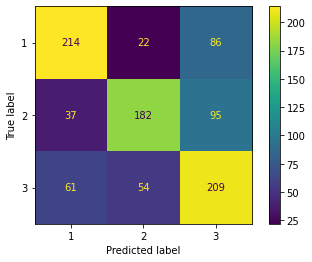


#### results for lowest loss model ####
Accuracy of: 0.6188


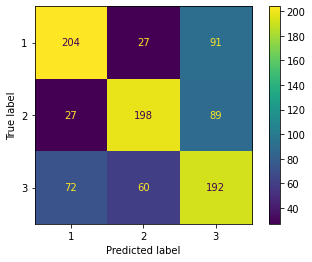


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9554 @ epoch 698
Best training loss (min) 0.1778 @ epoch 943

Best validation accuracy (max) 0.8681 @ epoch 947
Best validation loss (min) 0.4117 @ epoch 782

#### results for highest accuracy model ####
Accuracy of: 0.6726


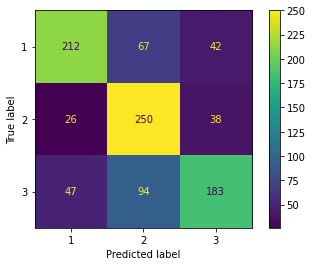


#### results for lowest loss model ####
Accuracy of: 0.6851


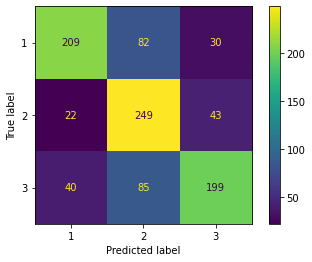


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.8553 @ epoch 948
Best training loss (min) 0.413 @ epoch 948

Best validation accuracy (max) 0.7361 @ epoch 166
Best validation loss (min) 0.6617 @ epoch 75

#### results for highest accuracy model ####
Accuracy of: 0.6513


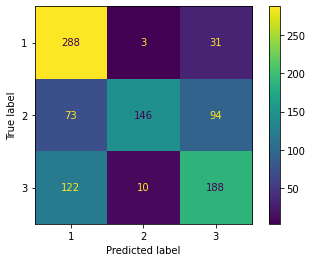


#### results for lowest loss model ####
Accuracy of: 0.6702


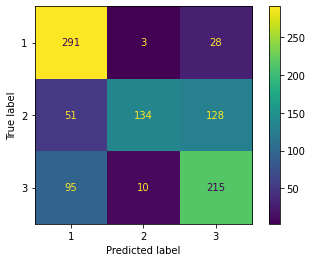

In [18]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset